In [1]:
# Config
import copy
import os
import numpy as np
from numpy.linalg import norm
import matplotlib
import matplotlib.pyplot as plt

# Path for ffmpeg (if animations are needed)
plt.rcParams['animation.ffmpeg_path'] = "C:\\Users\\Fredric\\Documents\\ffmpeg\\ffmpeg-n4.4-latest-win64-gpl-4.4\\bin\\ffmpeg.exe"

# Path for .pkl files output
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\tungurahua\\"
target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\conduit_flow\\"
# target_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\scenarios\\results_dx4m\\"

# Path for Quail source code
source_dir = "C:\\Users\\Fredric\\Documents\\Volcano\\quail_volcano\\src\\"

# Path for Quail entry point
quail_path = os.path.join(source_dir, "quail")

# Name of file to run (must be located in target_dir)
target_file = "conduit_p.py"

In [2]:
%load_ext autoreload
%autoreload 2

# Import quail modules
os.chdir(source_dir)
import argparse
import importlib
import sys
import scipy

import defaultparams as default_deck
import errors
from general import ShapeType, SolverType, PhysicsType

import meshing.common as mesh_common
import meshing.gmsh as mesh_gmsh
import meshing.tools as mesh_tools

import numerics.helpers.helpers as helpers
import numerics.timestepping.tools as stepper_tools

import physics.zerodimensional.zerodimensional as zerod
import physics.euler.euler as euler
import physics.navierstokes.navierstokes as navierstokes
import physics.scalar.scalar as scalar
import physics.chemistry.chemistry as chemistry
import physics.multiphasevpT.multiphasevpT as multiphasevpT

import processing.readwritedatafiles as readwritedatafiles
import processing.post as post
import processing.plot as plot
import processing
import processing.mdtools as mdtools

import solver.DG as DG
import solver.ADERDG as ADERDG
import solver.tools as solver_tools

import time
import multiprocessing as mp
from multidomain import Domain, Observer

os.chdir(target_dir)

In [3]:
# Parallel, 1D-2D coupled
# solver1D_par = lambda solver_idx, i: readwritedatafiles.read_data_file(
#   f"debug_output/r1conduitdx1_debug_sub{solver_idx}_{i}.pkl")
# solver1D_par = lambda solver_idx, i: readwritedatafiles.read_data_file(
#   f"sherlock_files/r1conduitdx1_debug_sub{solver_idx}_{i}.pkl")
solver1D_par_coarse = lambda solver_idx, i: readwritedatafiles.read_data_file(
  f"conduit_dx1_T4/output/r1conduitdx1_T4_sub{solver_idx}_{i}.pkl")
solver1D_par_fine = lambda solver_idx, i: readwritedatafiles.read_data_file(
  f"conduit_dx250e-3_T4/output/r1conduitdx250e-3_T4_sub{solver_idx}_{i}.pkl")
# solver1D_from = lambda i: readwritedatafiles.read_data_file(
#   f"debug_output/r1conduitdx1_debug_{i}.pkl")

  
# solver2D_par = lambda solver_idx, i: readwritedatafiles.read_data_file(
#   f"par1D2D_test_atm_sub{solver_idx}_{i}.pkl")

# Production, parallel 1D
# solver1D_from = lambda i: readwritedatafiles.read_data_file(
  # f"../conduit_flow/debug_output/r1conduit_{i}.pkl")
# solver1D_from = lambda i: readwritedatafiles.read_data_file(
#   f"../conduit_flow/debug_output/r1conduit_{i}.pkl")

In [4]:
solver1D_from = lambda i: solver1D_par(0,i)
solver1D_from(300).time

NameError: name 'solver1D_par' is not defined

In [208]:
plt.figure(1)
plt.clf()
i = 250
plt.plot(solver1D_from(i).elem_helpers.x_elems.ravel(),
  solver1D_from(i).state_coeffs[...,5:6].ravel() /
  solver1D_from(i).state_coeffs[...,0:3].sum(axis=-1).ravel())

In [204]:
%matplotlib tk
''' General inspect plots '''

from cycler import cycler

solver0 = solver1D_par(0,0)
qty_name = "Pressure"

num_curves = 10
plt.figure(1)
plt.clf()
plt.gca().set_prop_cycle(cycler('color',
  [plt.cm.Spectral(i) for i in np.linspace(0,0.8,num_curves)]))

# x, p0 = mdtools.downsample(solver0, qty_name)
# plt.plot(x.ravel(), p0.ravel())

for i in np.unique(np.linspace(0,300,num_curves).astype(int)):
  solver = solver1D_par(0,i)
  x_ = solver.elem_helpers.x_elems
  q = solver.physics.compute_variable(qty_name, solver.state_coeffs).ravel()

  # q = solver.state_coeffs[...,0:1] \
  #   / solver.state_coeffs[...,0:3].sum(axis=-1, keepdims=True)
  plt.plot(x_.ravel(), q.ravel(), '.-', label=f"t = {solver.time:.2f} s")

plt.legend()

In [206]:
%matplotlib tk
''' Inspect all plots '''

from cycler import cycler

solver0 = solver1D_par(0,0)
qty_name = "Pressure"

num_curves = 10
plt.figure(2)
plt.clf()
# Set up subplots
for j in range(9):
  plt.subplot(3,3,j+1)
  plt.gca().set_prop_cycle(cycler('color',
    [plt.cm.Spectral(i) for i in np.linspace(0,0.8,num_curves)]))

# x, p0 = mdtools.downsample(solver0, qty_name)
# plt.plot(x.ravel(), p0.ravel())

for i in np.unique(np.linspace(0,300,num_curves).astype(int)):
  solver = solver1D_par(0,i)
  x_ = solver.elem_helpers.x_elems

  for j, qty_name in enumerate(
      ["Pressure", "Temperature", "XVelocity", "SoundSpeed"]):
    plt.subplot(3,3,j+1)
    q = solver.physics.compute_variable(qty_name, solver.state_coeffs).ravel()
    plt.plot(x_.ravel(), q.ravel(), '.-')
    plt.ylabel(qty_name)
  
  plt.subplot(3,3,5)
  q = solver.state_coeffs[...,1:2] \
    / solver.state_coeffs[...,0:3].sum(axis=-1, keepdims=True)
  plt.plot(x_.ravel(), q.ravel(), '.-', label=f"t = {solver.time:.2f} s")
  plt.ylabel("Exsolved water mass fraction")

  plt.subplot(3,3,6)
  q = solver.state_coeffs[...,5:6] \
    / solver.state_coeffs[...,0:3].sum(axis=-1, keepdims=True)
  plt.plot(x_.ravel(), q.ravel(), '.-', label=f"t = {solver.time:.2f} s")
  plt.ylabel("Total water mass fraction")

  plt.subplot(3,3,7)
  q = solver.state_coeffs[...,6:7] \
    / solver.state_coeffs[...,0:3].sum(axis=-1, keepdims=True)
  plt.plot(x_.ravel(), q.ravel(), '.-', label=f"t = {solver.time:.2f} s")
  plt.ylabel("Total crystal fraction")

  plt.subplot(3,3,9)
  plt.plot(x_.ravel()[0], q.ravel()[0], '-', label=f"t = {solver.time:.2f} s")
  plt.legend()



In [214]:
''' Full-domain plotting '''

# plt.figure(3)
# plt.clf()
# for domain_idx in range(8):
#   solver = solver1D_par(domain_idx, 300)
#   x_ = solver.elem_helpers.x_elems
#   # q = solver.state_coeffs[...,5:6] \
#       # / solver.state_coeffs[...,0:3].sum(axis=-1, keepdims=True)
#   q = solver.physics.compute_variable("phi", solver.state_coeffs).ravel()
#   plt.plot(x_.ravel(), q.ravel(), '.-')
# print(solver.time)

target = "XVelocity"

plt.figure(33)
plt.clf()
for domain_idx in range(8):
  solver = solver1D_par_fine(domain_idx, 300)
  x_ = solver.elem_helpers.x_elems
  # q = solver.state_coeffs[...,5:6] \
      # / solver.state_coeffs[...,0:3].sum(axis=-1, keepdims=True)
  q = solver.physics.compute_variable(target, solver.state_coeffs).ravel()
  plt.plot(x_.ravel(), q.ravel(), '.-')
print(solver.time)

plt.figure(34)
plt.clf()
for domain_idx in range(8):
  solver = solver1D_par_coarse(domain_idx, 150)
  x_ = solver.elem_helpers.x_elems
  # q = solver.state_coeffs[...,5:6] \
      # / solver.state_coeffs[...,0:3].sum(axis=-1, keepdims=True)
  q = solver.physics.compute_variable(target, solver.state_coeffs).ravel()
  plt.plot(x_.ravel(), q.ravel(), '.-')
print(solver.time)

14.999999999861293
15.000000000026116


In [224]:
solver1D_par_fine(0, 400)

DG(Physics: MultiphasevpT1D,
   		Basis: LagrangeSeg(order=2),
   Stepper: SSPRK3(TimeStep=3.125e-05))

In [112]:
''' Data ingestion '''

# num_output = 20
# Ingestion range
read_range = range(0, 401, 2)

num_domains = 12

# Alias for lowest subdomain
# solver1D_from = lambda i: solver1D_par(0, i)
solver1D_from = lambda i: solver1D_par_fine(0, i)

# Collated data array shape
# coll_shape = (len(list(read_range)), *np.concatenate(
#   [mdtools.downsample(solver1D_par(dom_idx, i), "Pressure")[1].ravel()
#     for dom_idx in range(num_domains)]).shape)
coll_shape = solver1D_par_fine(0,0).physics.compute_variable(
  "Pressure", solver1D_par_fine(0,0).state_coeffs).shape
coll_shape = (len(list(read_range)),
  coll_shape[0]*num_domains,
  *coll_shape[1:])

# Collate t
t_coll = np.vstack([solver1D_from(i).time for i in read_range])
# Collated size
p_coll = np.zeros(coll_shape)
u_coll = np.zeros(coll_shape)
c_coll = np.zeros(coll_shape)
# Collate component fractions
yWv_coll, yWt_coll, yC_coll, rho_coll, phi_coll = \
  p_coll.copy(), p_coll.copy(), p_coll.copy(), p_coll.copy(), p_coll.copy()
T_coll = p_coll.copy()
mu_coll = np.zeros(coll_shape)
mu_coeff_coll = mu_coll.copy()
test_aux = mu_coll.copy()


for i, file_idx in enumerate(read_range):
  loaded_vals = []
  loaded_mu = []
  loaded_mu_coeff = []
  loaded_test_p = []
  for j, dom_idx in enumerate(range(num_domains)):
    _solver = solver1D_par_fine(dom_idx, file_idx)
    # Extract list of values
    loaded_vals.append([
      _solver.physics.compute_variable(qty, _solver.state_coeffs)
      for qty in
      ["pDensityA", "pDensityWv", "pDensityM", "pDensityWt", "pDensityC",
       "Pressure", "XVelocity", "SoundSpeed", "phi", "Temperature"]])
    # Extract viscosity
    loaded_mu.append(_solver.physics.source_terms[1].get_source(_solver.physics,
      _solver.state_coeffs, _solver.elem_helpers.x_elems, None)[...,3:4])
    loaded_mu_coeff.append(_solver.physics.source_terms[1].compute_viscosity(
      _solver.state_coeffs, _solver.physics))
    loaded_test_p.append(_solver.physics.compute_variable("Pressure",
      _solver.state_coeffs))
  # Merge data of sub domains affects axis=1
  fused_data = np.moveaxis(np.array(loaded_vals), (0,2), (-2,-1))
  fused_data = np.reshape(fused_data, 
    (*fused_data.shape[:-2], np.prod(fused_data.shape[-2:])))
  fused_data = np.moveaxis(np.array(fused_data), -1, 1)
  # Extract desired quantities (index in qty_list above)
  rho_coll[i,:] = fused_data[0,:] + fused_data[1,:] + fused_data[2,:]
  yWv_coll[i,:] = fused_data[1,:] / rho_coll[i,:]
  yWt_coll[i,:] = fused_data[3,:] / rho_coll[i,:]
  yC_coll[i,:] = fused_data[4,:] / rho_coll[i,:]
  p_coll[i,:] = fused_data[5,:]
  u_coll[i,:] = fused_data[6,:]
  c_coll[i,:] = fused_data[7,:]
  phi_coll[i,:] = fused_data[8,:]
  T_coll[i,:] = fused_data[9,:]
  # Load mu
  _lm = (np.moveaxis(np.array(loaded_mu), (0,1), (-2,-1)))
  mu_coll[:] = (np.moveaxis(np.reshape(_lm,
    (*_lm.shape[:-2], np.prod(_lm.shape[-2:]))), -1, 0))   
  _lm = (np.moveaxis(np.array(loaded_mu_coeff), (0,1), (-2,-1)))
  mu_coeff_coll[:] = (np.moveaxis(np.reshape(_lm,
    (*_lm.shape[:-2], np.prod(_lm.shape[-2:]))), -1, 0))
  _lm = (np.moveaxis(np.array(loaded_test_p), (0,1), (-2,-1)))
  test_aux[:] = (np.moveaxis(np.reshape(_lm,
    (*_lm.shape[:-2], np.prod(_lm.shape[-2:]))), -1, 0))

# Mesh
x = np.vstack([solver1D_par_fine(i,0).elem_helpers.x_elems for i in range(num_domains)])

In [111]:
np.array(loaded_test_p).shape
_lm = (np.moveaxis(np.array(loaded_test_p), (0,1), (-1,-2))).shape
(np.moveaxis(np.reshape(np.moveaxis(_lm, (0,1), (-2,-1)),
    (*_lm.shape[:-2], np.prod(_lm.shape[-2:]))), -1, 0))

(3, 1, 1000, 12)

In [113]:
plt.figure(1001)
plt.clf()
plt.subplot(1,2,1)
plt.plot(x.ravel(), test_aux[-1, ...].ravel())
plt.subplot(1,2,2)
plt.plot(x.ravel(), p_coll[-1, ...].ravel())


In [116]:
''' Data ingestion '''

# num_output = 20
# Ingestion range
read_range = range(0, 201, 1)

num_domains = 12

# Alias for lowest subdomain
# solver1D_from = lambda i: solver1D_par(0, i)
solver1D_from = lambda i: solver1D_par_coarse(0, i)

# Collated data array shape
# coll_shape = (len(list(read_range)), *np.concatenate(
#   [mdtools.downsample(solver1D_par(dom_idx, i), "Pressure")[1].ravel()
#     for dom_idx in range(num_domains)]).shape)
coll_shape = solver1D_par_coarse(0,0).physics.compute_variable(
  "Pressure", solver1D_par_coarse(0,0).state_coeffs).shape
coll_shape = (len(list(read_range)),
  coll_shape[0]*num_domains,
  *coll_shape[1:])

# Collate t
t_collc = np.vstack([solver1D_from(i).time for i in read_range])
# Allocate
p_collc = np.zeros(coll_shape)
u_collc = np.zeros(coll_shape)
c_collc = np.zeros(coll_shape)
yWv_collc, yWt_collc, yC_collc, rho_collc, phi_collc = \
  p_collc.copy(), p_collc.copy(), p_collc.copy(), p_collc.copy(), p_collc.copy()
T_collc = p_collc.copy()
mu_collc = np.zeros(coll_shape)
mu_coeff_collc = mu_collc.copy()

for i, file_idx in enumerate(read_range):
  loaded_vals = []
  loaded_mu = []
  loaded_mu_coeff = []
  for j, dom_idx in enumerate(range(num_domains)):
    _solver = solver1D_par_coarse(dom_idx, file_idx)
    # Extract list of values
    loaded_vals.append([
      _solver.physics.compute_variable(qty, _solver.state_coeffs)
      for qty in
      ["pDensityA", "pDensityWv", "pDensityM", "pDensityWt", "pDensityC",
       "Pressure", "XVelocity", "SoundSpeed", "phi", "Temperature"]])
    # Extract viscosity
    loaded_mu.append(_solver.physics.source_terms[1].get_source(_solver.physics,
      _solver.state_coeffs, _solver.elem_helpers.x_elems, None)[...,3:4])
    loaded_mu_coeff.append(_solver.physics.source_terms[1].compute_viscosity(
      _solver.state_coeffs, _solver.physics))
  # Merge data of sub domains affects axis=1
  fused_data = np.moveaxis(np.array(loaded_vals), (0,2), (-2,-1))
  fused_data = np.reshape(fused_data, 
    (*fused_data.shape[:-2], np.prod(fused_data.shape[-2:])))
  fused_data = np.moveaxis(np.array(fused_data), -1, 1)
  # Extract desired quantities (index in qty_list above)
  rho_collc[i,:] = fused_data[0,:] + fused_data[1,:] + fused_data[2,:]
  yWv_collc[i,:] = fused_data[1,:] / rho_collc[i,:]
  yWt_collc[i,:] = fused_data[3,:] / rho_collc[i,:]
  yC_collc[i,:] = fused_data[4,:] / rho_collc[i,:]
  p_collc[i,:] = fused_data[5,:]
  u_collc[i,:] = fused_data[6,:]
  c_collc[i,:] = fused_data[7,:]
  phi_collc[i,:] = fused_data[8,:]
  T_collc[i,:] = fused_data[9,:]
  # Load mu
  _lm = (np.moveaxis(np.array(loaded_mu), (0,1), (-2,-1)))
  mu_collc[:] = (np.moveaxis(np.reshape(_lm,
    (*_lm.shape[:-2], np.prod(_lm.shape[-2:]))), -1, 0))   
  _lm = (np.moveaxis(np.array(loaded_mu_coeff), (0,1), (-2,-1)))
  mu_coeff_collc[:] = (np.moveaxis(np.reshape(_lm,
    (*_lm.shape[:-2], np.prod(_lm.shape[-2:]))), -1, 0))

# Mesh
xc = np.vstack([solver1D_par_coarse(i,0).elem_helpers.x_elems for i in range(num_domains)])

In [301]:
_lm = (np.moveaxis(np.array(loaded_mu), (0,1), (-2,-1)))
loaded_mu[:] = (np.moveaxis(np.reshape(np.moveaxis(_lm, (0,1), (-2,-1)),
  (*_lm.shape[:-2], np.prod(_lm.shape[-2:]))), -1, 0))

(3000, 3, 1)

In [237]:
# Fine coarse comparison
t_coll.max(), t_collc.max()

(19.99999999974306, 20.00000000004999)

In [13]:
plt.semilogy(x.ravel(), 0.5 * conduit_radius * -mu_coll[-1].ravel())
plt.xlabel("depth (m)")
plt.ylabel("(Pa)")

NameError: name 'conduit_radius' is not defined

In [152]:
%matplotlib tk
# Spatial fft on latest slice
plt.figure(12, figsize=(12,6))
plt.clf()

plt.subplot(2,1,1)
# Interpolate to evenly spaced signal
x_sample = np.linspace(x.min(), x.max(), len(x.ravel()))
p_signal = np.interp(x_sample,
  x.ravel(),
  p_coll[-1,:].ravel())
dx = x_sample[1] - x_sample[0]
# Linear wavenumber axis
lineark_axis = np.linspace(0.0, 0.5/dx, p_signal.size//2)
Z = np.fft.fft(p_signal)
plt.semilogy(lineark_axis, np.abs(Z)[:p_signal.size//2], '.-')
plt.xlabel("Linear wavenumber (1/m)")
plt.ylabel("Pressure-hat (Pa / (1/m))")
secax_x = plt.gca().secondary_xaxis("top",
  functions=(lambda x: 1/(1e-15+x), lambda x: 1/(1e-15+x)))
secax_x.set_xlabel("Wavelength (m)")
# secax_x.set_xticks(np.flip(np.logspace(np.log10(1/3.0), np.log10(1/0.2), 6)))
secax_x.set_xticks([1/3, 1/2, 2/3, 1, 2, 4])
plt.grid(visible=True, which="both", axis="both")

plt.subplot(2,1,2)
# Repeat for u signal
u_signal = np.interp(x_sample,
  x.ravel(),
  u_coll[-1,:].ravel())
dx = x_sample[1] - x_sample[0]
# Linear wavenumber axis
lineark_axis = np.linspace(0.0, 0.5/dx, u_signal.size//2)
Z = np.fft.fft(u_signal)
plt.semilogy(lineark_axis, np.abs(Z)[:u_signal.size//2], '.-')
plt.xlabel("Linear wavenumber (1/m)")
plt.ylabel("Velocity-hat (m/s / (1/m))")
secax_x = plt.gca().secondary_xaxis("top",
  functions=(lambda x: 1/(1e-15+x), lambda x: 1/(1e-15+x)))
secax_x.set_xlabel("Wavelength (m)")
# secax_x.set_xticks(np.flip(np.logspace(np.log10(1/3.0), np.log10(1/0.2), 6)))
secax_x.set_xticks([1/3, 1/2, 2/3, 1, 2, 4])
plt.grid(visible=True, which="both", axis="both")

In [135]:
''' Plot pressure '''
plt.figure(20)
plt.clf()
plt.plot(x.ravel(), p_coll[-1,...].ravel(), '.')

In [234]:
x.max()

-1150.0281754163448

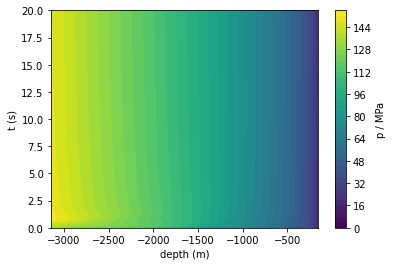

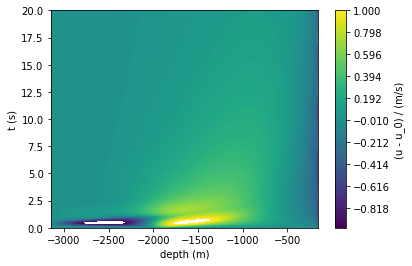

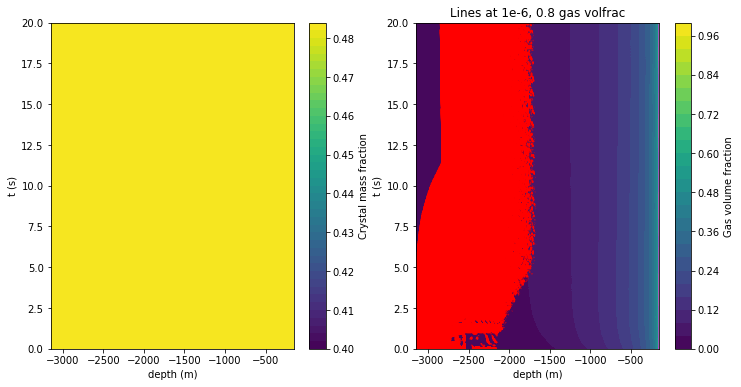

In [15]:
''' Generate state(x,t)-contourf '''
x_mg, t_mg = np.meshgrid(x.ravel(), t_coll.ravel())

plt.figure(7)
plt.clf()
plt.contourf(x_mg, t_mg,
  np.reshape(p_coll, (-1, np.prod(p_coll.shape[1:])))/1e6,
  levels=50)
cb = plt.colorbar()
cb.set_label("p / MPa")
plt.xlabel("depth (m)")
plt.ylabel("t (s)")

plt.figure(8)
plt.clf()
# plt.contourf(x_mg, t_mg, np.log(u_coll), levels=100)
# cb = plt.colorbar()
# cb.set_label("log u / (m/s)")
plt.contourf(x_mg, t_mg,
  np.reshape(u_coll-u_coll[0,:], (-1, np.prod(u_coll.shape[1:]))),
  levels=np.linspace(-1,1,100))
cb = plt.colorbar()
cb.set_label("(u - u_0) / (m/s)")
plt.xlabel("depth (m)")
plt.ylabel("t (s)")
# plt.clim(-0.1, 0.1)

plt.figure(9, figsize=(12,6))
plt.clf()
plt.subplot(1,2,1)
plt.contourf(x_mg, t_mg,
  np.reshape(yC_coll, (-1, np.prod(yC_coll.shape[1:]))),
  levels=50)
cb = plt.colorbar()
plt.xlabel("depth (m)")
plt.ylabel("t (s)")
cb.set_label("Crystal mass fraction")

plt.subplot(1,2,2)
plt.contourf(x_mg, t_mg,
  np.reshape(phi_coll, (-1, np.prod(phi_coll.shape[1:]))),
  levels=25)
cb = plt.colorbar()
plt.contour(x_mg, t_mg,
  np.reshape(phi_coll, (-1, np.prod(phi_coll.shape[1:]))),
  levels=[1e-6, 0.8], colors=["red", "magenta"])
plt.xlabel("depth (m)")
plt.ylabel("t (s)")
plt.title("Lines at 1e-6, 0.8 gas volfrac")
cb.set_label("Gas volume fraction")

In [181]:
plt.figure(13)
plt.clf()
plt.plot(x.ravel(), phi_coll[-1,:].ravel(), '.-')
plt.xlabel("depth (m)")
plt.ylabel("gas volfrac")

Text(0, 0.5, 'gas volfrac')

In [167]:
plt.subplot(1,2,2)
plt.contourf(x_mg, t_mg,
  np.reshape(yWv_coll, (-1, np.prod(yC_coll.shape[1:]))),
  levels=25)
cb = plt.colorbar()
plt.contour(x_mg, t_mg,
  np.reshape(yWv_coll, (-1, np.prod(yC_coll.shape[1:]))),
  levels=[1e-3], colors="red")

plt.xlabel("depth (m)")
plt.ylabel("t (s)")
cb.set_label("Crystal mass fraction")

In [257]:
yC_fn = lambda t: 0.4025 * (1.1 - 0.1 * np.cos(2*np.pi*t/4.0))
yWt_fn = lambda t: 0.05055 / (1.0 + 0.05055) * (1.0 - 0.4025 * (1.1 - 0.1 * np.cos(2*np.pi*0.0/4.0)))

(201, 12000, 3, 1)

(100000.0, 1000000000.0)

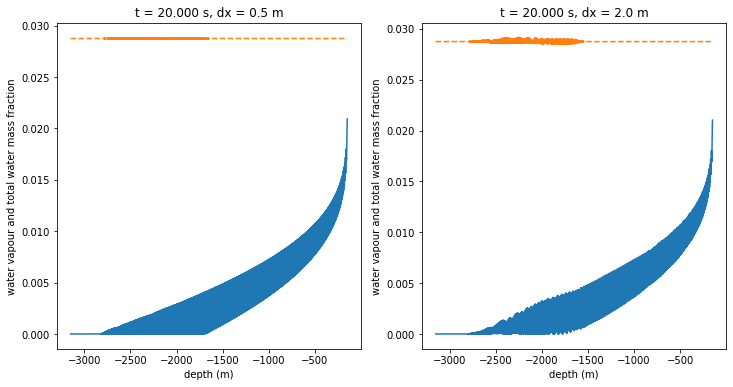

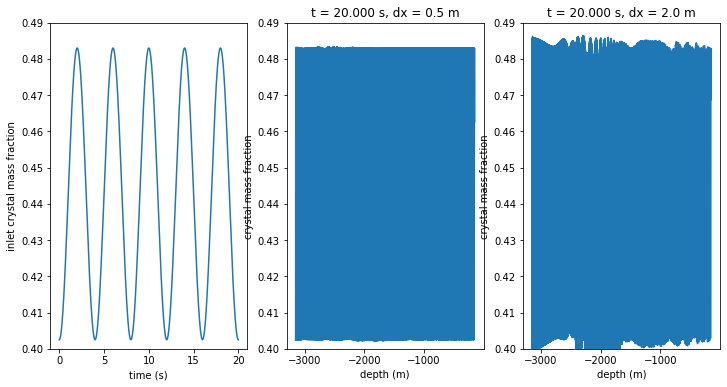

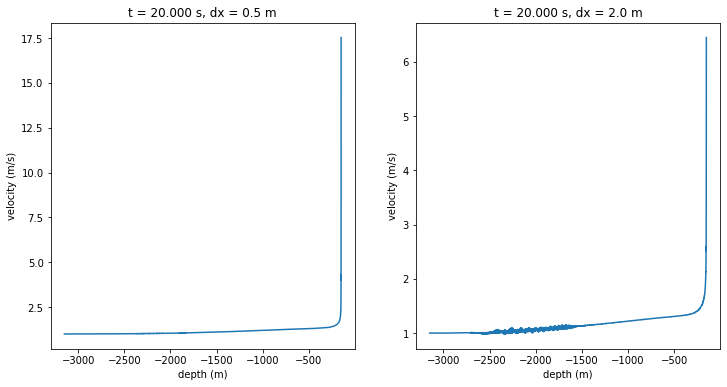

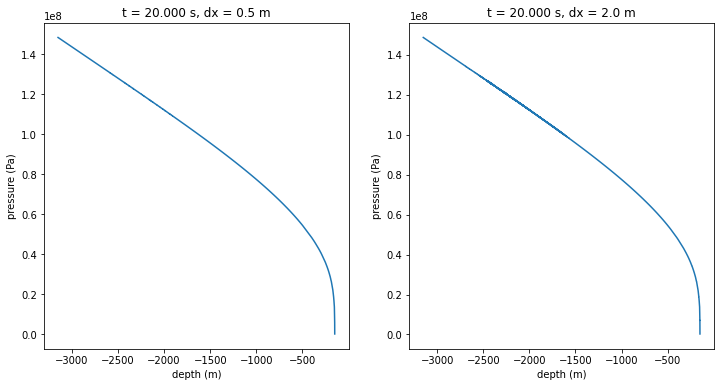

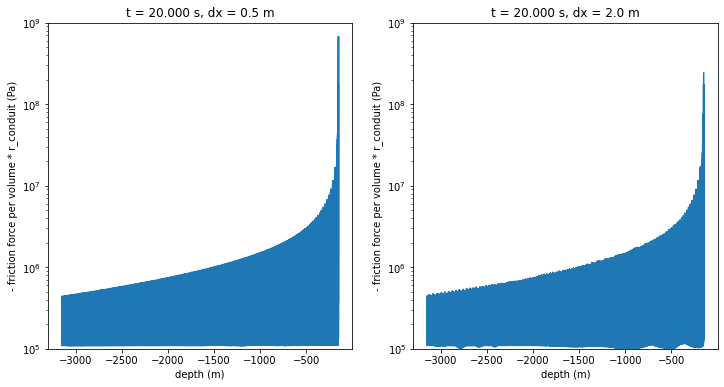

In [17]:
'''Side-by-side plotting ''' 

plt.figure(101, figsize=(12,6))
plt.clf()
plt.subplot(1,2,1)
plt.plot(x_mg[-1,:], yWv_coll[-1,...].ravel())
plt.plot(x_mg[-1,:], yWt_coll[-1,...].ravel(), '--')
plt.title(f"t = {t_coll.ravel()[-1]:.3f} s, dx = 0.5 m")
plt.xlabel("depth (m)")
plt.ylabel("water vapour and total water mass fraction")

plt.subplot(1,2,2)
plt.plot(xc.ravel(), yWv_collc[-1,...].ravel())
plt.plot(xc.ravel(), yWt_collc[-1,...].ravel(), '--')
plt.title(f"t = {t_collc.ravel()[-1]:.3f} s, dx = 2.0 m")
plt.xlabel("depth (m)")
plt.ylabel("water vapour and total water mass fraction")

plt.figure(102, figsize=(12,6))
plt.clf()
plt.subplot(1,3,1)
yC_fn = lambda t: 0.4025 * (1.1 - 0.1 * np.cos(2*np.pi*t/4.0))
_t_test = np.linspace(0, t_coll.ravel()[-1], 1000)
plt.plot(_t_test, yC_fn(_t_test))
plt.ylim(0.4,0.49)
plt.xlabel("time (s)")
plt.ylabel("inlet crystal mass fraction")
plt.subplot(1,3,2)
plt.plot(x_mg[-1,:], yC_coll[-1,...].ravel())
plt.title(f"t = {t_coll.ravel()[-1]:.3f} s, dx = 0.5 m")
plt.ylim(0.4,0.49)
plt.xlabel("depth (m)")
plt.ylabel("crystal mass fraction")
plt.subplot(1,3,3)
plt.plot(xc.ravel(), yC_collc[-1,...].ravel())
plt.title(f"t = {t_collc.ravel()[-1]:.3f} s, dx = 2.0 m")
plt.ylim(0.4,0.49)
plt.xlabel("depth (m)")
plt.ylabel("crystal mass fraction")

plt.figure(103, figsize=(12,6))
plt.clf()
plt.subplot(1,2,1)
plt.plot(x_mg[-1,:], u_coll[-1,...].ravel())
plt.title(f"t = {t_coll.ravel()[-1]:.3f} s, dx = 0.5 m")
plt.xlabel("depth (m)")
plt.ylabel("velocity (m/s)")
plt.subplot(1,2,2)
plt.plot(xc.ravel(), u_collc[-1,...].ravel())
plt.title(f"t = {t_collc.ravel()[-1]:.3f} s, dx = 2.0 m")
plt.xlabel("depth (m)")
plt.ylabel("velocity (m/s)")

plt.figure(104, figsize=(12,6))
plt.clf()
plt.subplot(1,2,1)
plt.plot(x_mg[-1,:], p_coll[-1,...].ravel())
plt.title(f"t = {t_coll.ravel()[-1]:.3f} s, dx = 0.5 m")
plt.xlabel("depth (m)")
plt.ylabel("pressure (Pa)")
plt.subplot(1,2,2)
plt.plot(xc.ravel(), p_collc[-1,...].ravel())
plt.title(f"t = {t_collc.ravel()[-1]:.3f} s, dx = 2.0 m")
plt.xlabel("depth (m)")
plt.ylabel("pressure (Pa)")

plt.figure(105, figsize=(12,6))
plt.clf()
conduit_radius = solver1D_par_fine(0,0).physics.source_terms[1].conduit_radius
plt.subplot(1,2,1)
plt.semilogy(x_mg[-1,:], -(mu_coll*conduit_radius/2)[-1,...].ravel())
plt.title(f"t = {t_coll.ravel()[-1]:.3f} s, dx = 0.5 m")
plt.xlabel("depth (m)")
plt.ylabel("- friction force per volume * r_conduit (Pa)")
plt.ylim(1e5, 1e9)
plt.subplot(1,2,2)
plt.semilogy(xc.ravel(), -(mu_collc*conduit_radius/2)[-1,...].ravel())
plt.title(f"t = {t_collc.ravel()[-1]:.3f} s, dx = 2.0 m")
plt.xlabel("depth (m)")
plt.ylabel("- friction force per volume * r_conduit (Pa)")
plt.ylim(1e5, 1e9)

In [120]:
%matplotlib tk
plt.figure(123)
plt.clf()

conduit_radius = solver1D_par_fine(0,0).physics.source_terms[1].conduit_radius
plt.subplot(1,3,1)
plt.semilogy(x_mg[-1,:], -(mu_coll*conduit_radius/2)[-1,...].ravel(), '.-')
plt.title(f"t = {t_coll.ravel()[-1]:.3f} s, dx = 0.5 m")
plt.xlabel("depth (m)")
plt.ylabel("- friction force per volume * (r_conduit / 2) (Pa)")
# plt.ylim(1e5, 3e5)
plt.subplot(1,3,2)
plt.semilogy(x.ravel(), -(mu_coll*conduit_radius/2)[-1,...].ravel(), '.-')
plt.title(f"t = {t_collc.ravel()[-1]:.3f} s, dx = 0.5 m")
plt.xlabel("depth (m)")
plt.ylabel("- friction force per volume * (r_conduit / 2) (Pa)")
plt.xlim(-2840, -2780)
plt.ylim(1e5, 3e5)

plt.subplot(1,3,3)
# plt.semilogy(x.ravel(), -(mu_coll*conduit_radius/2)[-1,...].ravel(), '.-')
# plt.title(f"t = {t_collc.ravel()[-1]:.3f} s, dx = 0.5 m")
# plt.xlabel("depth (m)")
# plt.ylabel("- friction force per volume * (r_conduit / 2) (Pa)")
# plt.xlim(-2840, -2830)
# plt.ylim(1e5, 1e9)
for ie in range(1200,1600,1): # Manual range
  _loc_x = x[ie,...].ravel()
  _loc_y = -(mu_coll*conduit_radius/2)[-1,ie,...].ravel()
  _loc_x_interp = np.linspace(_loc_x.min(), _loc_x.max(), 5)
  _loc_y_interp = scipy.interpolate.BarycentricInterpolator(_loc_x, _loc_y)(_loc_x_interp)
  plt.semilogy(_loc_x, _loc_y, '.k')
  plt.semilogy(_loc_x_interp, _loc_y_interp, '-k')
plt.title(f"t = {t_collc.ravel()[-1]:.3f} s, dx = 0.5 m")
plt.xlabel("depth (m)")
plt.ylabel("- friction force per volume * (r_conduit / 2) (Pa)")
plt.xlim(-2840, -2830)
plt.ylim(1e5, 3e5)

plt.figure(124)
plt.clf()
conduit_radius = solver1D_par_fine(0,0).physics.source_terms[1].conduit_radius
plt.subplot(1,3,1)
plt.semilogy(xc.ravel(), -(mu_collc*conduit_radius/2)[-1,...].ravel(), '.-')
plt.title(f"t = {t_coll.ravel()[-1]:.3f} s, dx = 2 m")
plt.xlabel("depth (m)")
plt.ylabel("- friction force per volume * (r_conduit / 2) (Pa)")
# plt.ylim(1e5, 3e5)
plt.subplot(1,3,2)
plt.semilogy(xc.ravel(), -(mu_collc*conduit_radius/2)[-1,...].ravel(), '.-')
plt.title(f"t = {t_collc.ravel()[-1]:.3f} s, dx = 2 m")
plt.xlabel("depth (m)")
plt.ylabel("- friction force per volume * (r_conduit / 2) (Pa)")
plt.xlim(-2840, -2780)
plt.ylim(1e5, 3e5)
plt.subplot(1,3,3)
# plt.semilogy(xc.ravel(), -(mu_collc*conduit_radius/2)[-1,...].ravel(), '.-')
# plt.title(f"t = {t_collc.ravel()[-1]:.3f} s, dx = 2 m")
# plt.xlabel("depth (m)")
# plt.ylabel("- friction force per volume * (r_conduit / 2) (Pa)")
# plt.xlim(-2840, -2830)
# plt.ylim(1e5, 1e9)

for ie in range(300,400,1): # Manual range
  _loc_x = xc[ie,...].ravel()
  _loc_y = -(mu_collc*conduit_radius/2)[-1,ie,...].ravel()
  _loc_x_interp = np.linspace(_loc_x.min(), _loc_x.max(), 10)
  _loc_y_interp = scipy.interpolate.BarycentricInterpolator(_loc_x, _loc_y)(_loc_x_interp)
  plt.semilogy(_loc_x, _loc_y, '.k')
  plt.semilogy(_loc_x_interp, _loc_y_interp, '-k')
plt.title(f"t = {t_collc.ravel()[-1]:.3f} s, dx = 2 m")
plt.xlabel("depth (m)")
plt.ylabel("- friction force per volume * (r_conduit / 2) (Pa)")
plt.xlim(-2840, -2830)
plt.ylim(1e5, 3e5)


(100000.0, 300000.0)

In [53]:

# Cryst
plt.figure(125)
plt.clf()
plt.subplot(1,3,1)
plt.plot(x_mg[-1,:], yC_coll[-1,...].ravel(), '.-')
plt.title(f"t = {t_coll.ravel()[-1]:.3f} s, dx = 0.5 m")
plt.xlabel("depth (m)")
plt.ylabel("Crystal mass fraction")
plt.ylim(0.4, 0.5)
plt.subplot(1,3,2)
plt.plot(x.ravel(), yC_coll[-1,...].ravel(), '.-')
plt.title(f"t = {t_collc.ravel()[-1]:.3f} s, dx = 0.5 m")
plt.xlabel("depth (m)")
plt.ylabel("Crystal mass fraction")
plt.xlim(-2840, -2780)
plt.ylim(0.4, 0.5)

plt.subplot(1,3,3)
# plt.semilogy(x.ravel(), -(mu_coll*conduit_radius/2)[-1,...].ravel(), '.-')
# plt.title(f"t = {t_collc.ravel()[-1]:.3f} s, dx = 0.5 m")
# plt.xlabel("depth (m)")
# plt.ylabel("- friction force per volume * (r_conduit / 2) (Pa)")
# plt.xlim(-2840, -2830)
# plt.ylim(1e5, 1e9)
for ie in range(1200,1600,1): # Manual range
  _loc_x = x[ie,...].ravel()
  _loc_y = yC_coll[-1,ie,...].ravel()
  _loc_x_interp = np.linspace(_loc_x.min(), _loc_x.max(), 5)
  _loc_y_interp = scipy.interpolate.BarycentricInterpolator(_loc_x, _loc_y)(_loc_x_interp)
  plt.plot(_loc_x, _loc_y, '.k')
  plt.plot(_loc_x_interp, _loc_y_interp, '-k')
plt.title(f"t = {t_collc.ravel()[-1]:.3f} s, dx = 0.5 m")
plt.xlabel("depth (m)")
plt.ylabel("Crystal mass fraction")
plt.xlim(-2840, -2830)
plt.ylim(0.4, 0.5)


(0.4, 0.5)

In [126]:
# Water vapour

t_index = 1
plt.figure(126)
plt.clf()
plt.subplot(1,3,1)
plt.semilogy(x_mg[t_index,:], yWv_coll[t_index,...].ravel(), '.-')
plt.title(f"t = {t_coll.ravel()[t_index]:.3f} s, dx = 0.5 m")
plt.xlabel("depth (m)")
plt.ylabel("Exsolved water mass fraction")
# plt.ylim(0.4, 0.5)
plt.subplot(1,3,2)
plt.semilogy(x.ravel(), yWv_coll[t_index,...].ravel(), '.-')
plt.title(f"t = {t_collc.ravel()[t_index]:.3f} s, dx = 0.5 m")
plt.xlabel("depth (m)")
plt.ylabel("Exsolved water mass fraction")
plt.xlim(-2840, -2780)
# plt.ylim(0.4, 0.5)

plt.subplot(1,3,3)
# plt.semilogy(x.ravel(), -(mu_coll*conduit_radius/2)[-1,...].ravel(), '.-')
# plt.title(f"t = {t_collc.ravel()[-1]:.3f} s, dx = 0.5 m")
# plt.xlabel("depth (m)")
# plt.ylabel("- friction force per volume * (r_conduit / 2) (Pa)")
# plt.xlim(-2840, -2830)
# plt.ylim(1e5, 1e9)
for ie in range(1200,1600,1): # Manual range
  _loc_x = x[ie,...].ravel()
  _loc_y = yWv_coll[t_index,ie,...].ravel()
  _loc_x_interp = np.linspace(_loc_x.min(), _loc_x.max(), 5)
  _loc_y_interp = scipy.interpolate.BarycentricInterpolator(_loc_x, _loc_y)(_loc_x_interp)
  plt.semilogy(_loc_x, _loc_y, '.k')
  plt.semilogy(_loc_x_interp, _loc_y_interp, '-k')
plt.title(f"t = {t_collc.ravel()[t_index]:.3f} s, dx = 0.5 m")
plt.xlabel("depth (m)")
plt.ylabel("Exsolved water mass fraction")
plt.xlim(-2840, -2830)
# plt.ylim(0.4, 0.5)


(-2840.0, -2830.0)

In [103]:
crysVisc[-1,0:10,...].shape, meltVisc[-1,0:10,...].shape, mu_coeff_coll[-1,0:10,...].shape
s_crys = crysVisc[-1,0:10,...]
s_melt = meltVisc[-1,0:10,...]
s_mu = mu_coeff_coll[-1,0:10,...]

plt.figure(999)
plt.clf()
plt.plot((s_crys*s_melt).ravel(), '.')
plt.plot((s_mu).ravel(), '.')

In [92]:
test_U = _solver.state_coeffs[0:1,0:1,:]
test_mu = _solver.physics.source_terms[1].compute_viscosity(test_U,
  _solver.physics)
print(test_mu)
test_T = _solver.physics.compute_variable("Temperature", test_U)
print(test_T)

rho_test = test_U[...,0:3].sum(axis=-1)
yWv_test = test_U[...,1] / rho_test
yWt_test = test_U[...,5] / rho_test
yC_test = test_U[...,6] / rho_test

# Approximate liquid melt mass fraction (excludes air)
yL_test = 1.0 - yC_test - yWt_test
# Dissolved concentration
xD_test = (yWt_test - yWv_test) / yL_test

# Compute melt viscosity
log_mfWd = np.log(xD_test*100)
log10_vis = -3.545 + 0.833 * log_mfWd
log10_vis += (9601 - 2368 * log_mfWd) / (test_T.squeeze() - 195.7 - 32.25 * log_mfWd)
# log10_vis[(1 - phiM) > self.crit_volfrac] = 0 # turning off friction above fragmentation
meltVisc_test = 10**log10_vis

### Costa 2005b
alpha = 0.999916
phi_cr = 0.673
gamma = 3.98937
delta = 16.9386
B = 2.5
_crystal_ratio = yC_test/ (1.0 - yWv_test)
phi_ratio = _crystal_ratio / phi_cr
from scipy import special
denom = (1.0 - alpha * special.erf((np.sqrt(np.pi) / (2 * alpha)) *
  phi_ratio * (1 + phi_ratio**gamma)) )**(-B * phi_cr)
crysVisc_test = (1.0 + phi_ratio**delta) * denom

print(meltVisc_test*crysVisc_test)

[[[7958700.584804505]]]
[[[1001.784004703081]]]
[[7958700.941772482]]


In [101]:
T_coll.ravel()[0:10]

array([1000.1156537476966, 1000.1156472562138, 1000.115640764912 ,
       1000.115640764912 , 1000.1156342737903, 1000.1156277828491,
       1000.1156277828491, 1000.1156212920882, 1000.1156148015076,
       1000.1156148015076])

In [99]:
yA_ref = (_solver.state_coeffs[:,:,0] / _solver.state_coeffs[:,:,0:3].sum(axis=-1)).mean()

In [122]:
# Viscosity decomposition plot

# Approximate liquid melt mass fraction (excludes air)
yL_coll = 1.0 - yC_coll - yWt_coll
# Dissolved concentration
xD_coll = (yWt_coll - yWv_coll) / yL_coll

# Compute melt viscosity
log_mfWd = np.log(xD_coll*100)
log10_vis = -3.545 + 0.833 * log_mfWd
log10_vis += (9601 - 2368 * log_mfWd) / (T_coll - 195.7 - 32.25 * log_mfWd)
# log10_vis[(1 - phiM) > self.crit_volfrac] = 0 # turning off friction above fragmentation
meltVisc = 10**log10_vis

### Costa 2005b
alpha = 0.999916
phi_cr = 0.673
gamma = 3.98937
delta = 16.9386
B = 2.5
_crystal_ratio = yC_coll/ (1.0 - yWv_coll - yA_ref)
phi_ratio = _crystal_ratio / phi_cr
from scipy import special
denom = (1.0 - alpha * special.erf((np.sqrt(np.pi) / (2 * alpha)) *
  phi_ratio * (1 + phi_ratio**gamma)) )**(-B * phi_cr)
crysVisc = (1.0 + phi_ratio**delta) * denom


# Compute crystal-induced viscosity

# Water vapour
plt.figure(127)
plt.clf()
plt.subplot(2,3,1)
plt.semilogy(x_mg[-1,:], (meltVisc*crysVisc)[-1,...].ravel(), 'b.-')
plt.title(f"t = {t_coll.ravel()[-1]:.3f} s, dx = 0.5 m")
plt.xlabel("depth (m)")
plt.ylabel("Dissolution-dependent melt viscosity (Pa s)")
# plt.ylim(0.4, 0.5)
plt.subplot(2,3,2)
plt.semilogy(x_mg[-1,:], (meltVisc*crysVisc)[-1,...].ravel(), 'b.-')
plt.title(f"t = {t_collc.ravel()[-1]:.3f} s, dx = 0.5 m")
plt.xlabel("depth (m)")
# plt.ylabel("Dissolution-dependent melt viscosity (Pa s)")
plt.xlim(-2840, -2780)
# plt.ylim(0.4, 0.5)

plt.subplot(2,3,3)
# plt.semilogy(x.ravel(), -(mu_coll*conduit_radius/2)[-1,...].ravel(), '.-')
# plt.title(f"t = {t_collc.ravel()[-1]:.3f} s, dx = 0.5 m")
# plt.xlabel("depth (m)")
# plt.ylabel("- friction force per volume * (r_conduit / 2) (Pa)")
# plt.xlim(-2840, -2830)
# plt.ylim(1e5, 1e9)
for ie in range(1200,1600,1): # Manual range
  _loc_x = x[ie,...].ravel()
  _loc_y = (meltVisc*crysVisc)[-1,ie,...].ravel()
  _loc_x_interp = np.linspace(_loc_x.min(), _loc_x.max(), 5)
  _loc_y_interp = scipy.interpolate.BarycentricInterpolator(_loc_x, _loc_y)(_loc_x_interp)
  plt.semilogy(_loc_x, _loc_y, '.b')
  plt.semilogy(_loc_x_interp, _loc_y_interp, '-b')
plt.title(f"t = {t_collc.ravel()[-1]:.3f} s, dx = 0.5 m")
plt.xlabel("depth (m)")
# plt.ylabel("Dissolution-dependent melt viscosity (Pa s)")
plt.xlim(-2840, -2830)
# plt.ylim(0.4, 0.5)

plt.subplot(2,3,4)
plt.semilogy(x_mg[-1,:], crysVisc[-1,...].ravel(), 'r.-')
plt.title(f"t = {t_coll.ravel()[-1]:.3f} s, dx = 0.5 m")
plt.xlabel("depth (m)")
plt.ylabel("Crystal-fraction-dependent viscosity factor")
# plt.ylim(0.4, 0.5)
plt.subplot(2,3,5)
plt.semilogy(x.ravel(), crysVisc[-1,...].ravel(), 'r.-')
plt.title(f"t = {t_collc.ravel()[-1]:.3f} s, dx = 0.5 m")
plt.xlabel("depth (m)")
# plt.ylabel("Crystal-fraction-dependent viscosity factor")
plt.xlim(-2840, -2780)
# plt.ylim(0.4, 0.5)

plt.subplot(2,3,6)
# plt.semilogy(x.ravel(), -(mu_coll*conduit_radius/2)[-1,...].ravel(), '.-')
# plt.title(f"t = {t_collc.ravel()[-1]:.3f} s, dx = 0.5 m")
# plt.xlabel("depth (m)")
# plt.ylabel("- friction force per volume * (r_conduit / 2) (Pa)")
# plt.xlim(-2840, -2830)
# plt.ylim(1e5, 1e9)
for ie in range(1200,1600,1): # Manual range
  _loc_x = x[ie,...].ravel()
  _loc_y = crysVisc[-1,ie,...].ravel()
  _loc_x_interp = np.linspace(_loc_x.min(), _loc_x.max(), 5)
  _loc_y_interp = scipy.interpolate.BarycentricInterpolator(_loc_x, _loc_y)(_loc_x_interp)
  plt.semilogy(_loc_x, _loc_y, '.r')
  plt.semilogy(_loc_x_interp, _loc_y_interp, '-r')
plt.title(f"t = {t_collc.ravel()[-1]:.3f} s, dx = 0.5 m")
plt.xlabel("depth (m)")
# plt.ylabel("Crystal-fraction-dependent viscosity factor")
plt.xlim(-2840, -2830)
# plt.ylim(0.4, 0.5)


(-2840.0, -2830.0)

In [44]:
# Interior basis representation
plt.figure(125)
plt.clf()
import scipy.interpolate

for ie in range(300,400,1):
  _loc_x = xc[ie,...].ravel()
  _loc_y = -(mu_collc*conduit_radius/2)[-1,ie,...].ravel()
  _loc_x_interp = np.linspace(_loc_x.min(), _loc_x.max(), 10)
  _loc_y_interp = scipy.interpolate.BarycentricInterpolator(_loc_x, _loc_y)(_loc_x_interp)
  plt.semilogy(_loc_x, _loc_y, '.k')
  plt.semilogy(_loc_x_interp, _loc_y_interp, '-k')
plt.title(f"t = {t_collc.ravel()[-1]:.3f} s, dx = 2 m")
plt.xlabel("depth (m)")
plt.ylabel("- friction force per volume * (r_conduit / 2) (Pa)")
plt.xlim(-2840, -2830)
plt.ylim(1e5, 1e9)

(100000.0, 1000000000.0)

In [37]:
_loc_x_interp

array([-2950.887298334621 , -2950.8012320380385, -2950.715165741456 ,
       -2950.6290994448736, -2950.543033148291 , -2950.456966851709 ,
       -2950.3709005551264, -2950.284834258544 , -2950.1987679619615,
       -2950.112701665379 ])

In [158]:
plt.subplot(1,2,2)
plt.contourf(x_mg, t_mg,
  np.reshape(yWv_coll, (-1, np.prod(yC_coll.shape[1:]))),
  levels=50)
cb = plt.colorbar()
plt.xlabel("depth (m)")
plt.ylabel("t (s)")
cb.set_label("Crystal mass fraction")

In [148]:
''' Show characteristic lines '''
# Use with downsampling (evenly spaced)

plt.figure(10)
plt.clf()

if True:

  x_sample = np.linspace(x.min(), x.max(), len(x.ravel()))
  sample_to_regular = lambda vals: np.vstack([
    np.interp(x_sample, x.ravel(), vals[i,:].ravel())
    for i in range(vals.shape[0])])
  u_regular = sample_to_regular(u_coll)
  c_regular = sample_to_regular(c_coll)
  x_mg_regular, t_mg_regular = np.meshgrid(x_sample.ravel(), t_coll.ravel())

  w = u_regular + c_regular
  plt.streamplot(x_mg_regular, t_mg_regular, w, np.ones_like(w),
    density=1, maxlength=10, color="blue", arrowsize=2.5)
  w = u_regular - c_regular
  plt.streamplot(x_mg_regular, t_mg_regular, w, np.ones_like(w),
    density=1, maxlength=10, color="red", arrowsize=2.5)
  plt.streamplot(x_mg_regular, t_mg_regular, u_regular, np.ones_like(w),
    density=0.25, maxlength=10, color="black", arrowsize=2.5)
  plt.xlabel("Depth (m)")
  plt.ylabel("Time (s)")
else:
  # Folding required if multiple values at same location 
  # Folding at interior shared nodes (downsample only returns boundary vals)
  fold = lambda mg: np.hstack(
    (mg[:,:0], 0.5 * (mg[:, 1:-1:2] + mg[:, 2::2]), mg[:,-1:]))
  w = u_coll + c_coll
  plt.streamplot(fold(x_mg), fold(t_mg), fold(w), fold(np.ones_like(w)),
    density=1, maxlength=10, color="blue", arrowsize=2.5)
  w = u_coll - c_coll
  plt.streamplot(fold(x_mg), fold(t_mg), fold(w), fold(np.ones_like(w)),
    density=1, maxlength=10, color="red", arrowsize=2.5)
  plt.streamplot(fold(x_mg), fold(t_mg), fold(u_coll), fold(np.ones_like(w)),
    density=0.25, maxlength=10, color="black", arrowsize=2.5)

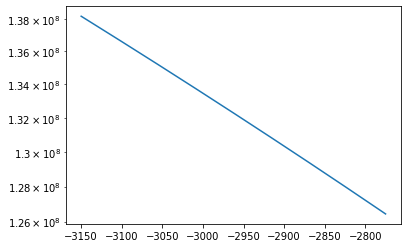

In [72]:
%matplotlib inline
''' Test load and get mesh. '''
x, p0 = mdtools.downsample(solver1D_from(0), "Pressure")
plt.semilogy(x.ravel(), p0.ravel())

## 2D Inspect

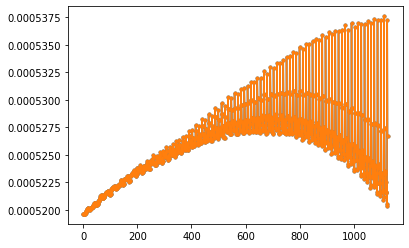

In [73]:
solve0 = solver1D_from(0)
solver1 = solver1D_from(5)
solver = solver1D_from(10)
Uc = solver.state_coeffs

u = solver1.physics.compute_variable("XVelocity", Uc)
c = solver1.physics.compute_variable("SoundSpeed", Uc)
M = u / c
plt.plot(M.ravel(), '.-')

u = solver.physics.compute_variable("XVelocity", Uc)
c = solver.physics.compute_variable("SoundSpeed", Uc)
M = u / c
plt.plot(M.ravel(), '.-')

solver2D = readwritedatafiles.read_data_file(
  f"../conduit_flow/steadyState_smoothing/r1atm1_120.pkl")

In [140]:
solver.physics.IC.f.x_mesh.shape

(67999,)

Choking acceleration is underresolved


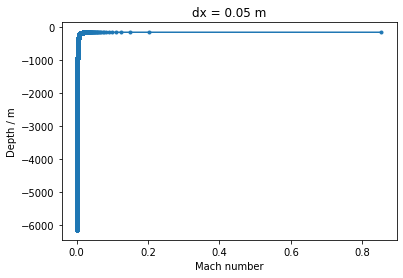

In [168]:
ssf = solver.physics.IC.f
x_fine = np.expand_dims(np.linspace(-6150,-150,120000),axis=(1,2))
U_ss = ssf(x_fine)
u = U_ss[...,3] / U_ss[...,0:3].sum(axis=2)
c = solver.physics.compute_variable("SoundSpeed", U_ss)[...,0]
M = u / c
plt.plot(M.ravel(), x_fine.squeeze(), '.-')
plt.xlabel("Mach number")
plt.ylabel("Depth / m")
plt.title("dx = 0.05 m")
print("Choking acceleration is underresolved")

In [157]:
M.shape

(60000, 3)

In [109]:
(x2D).squeeze().shape

(486, 3, 2)

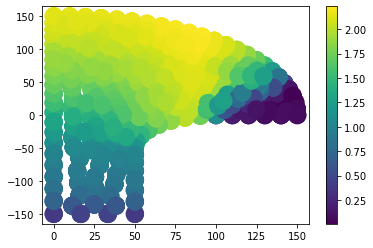

In [118]:
x2D, v2D = mdtools.downsample(solver2D, "Velocity")
x2D, c2D = mdtools.downsample(solver2D, "SoundSpeed")

plt.scatter(x2D[...,0], x2D[...,1], c=(v2D/c2D).squeeze(), s=300)
plt.colorbar()

In [122]:
solver1D_from(10).physics.BCs

{'x1': <physics.multiphasevpT.functions.VelocityInlet1D at 0x25a440ffd90>,
 'x2': <physics.multiphasevpT.functions.PressureOutlet1D at 0x25a440ffe20>}

In [69]:
p[np.argmin(np.abs(p - 1.6e8)):]
x[trunc_slice]

array([[-3841.5],
       [-3838.5],
       [-3835.5],
       ...,
       [ -160.5],
       [ -157.5],
       [ -154.5]])

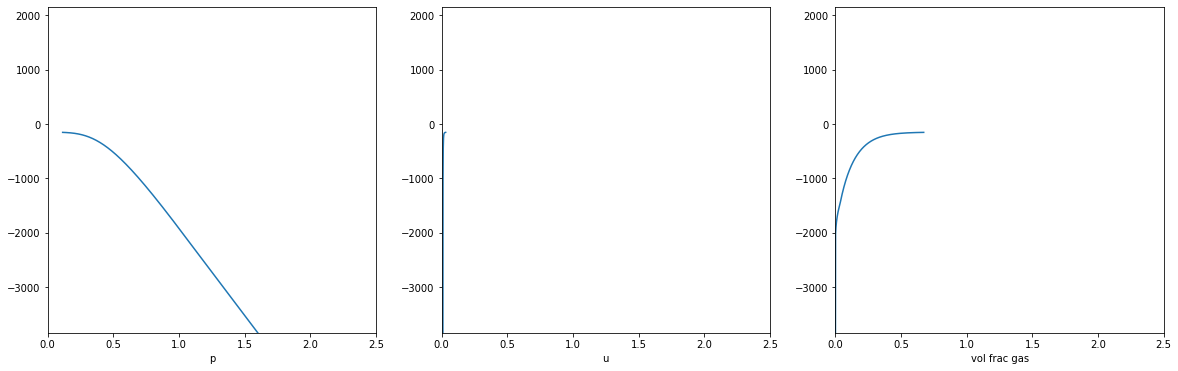

In [70]:
''' Truncation to lower pressures ''' 

x, p = mdtools.downsample(solver1D_from(0), "Pressure")
x, u = mdtools.downsample(solver1D_from(0), "XVelocity")
x, phi = mdtools.downsample(solver1D_from(0), "phi")
x, p, u, phi, = np.mean(x,axis=1), np.mean(p,axis=1), \
  np.mean(u,axis=1), np.mean(phi,axis=1)

trunc_slice = slice(np.argmin(np.abs(p - 1.6e8)),-1)
# plt.plot(x[trunc_slice].ravel(), x[trunc_slice].ravel())
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.plot(p[trunc_slice].ravel()/1e8, x[trunc_slice].ravel())
plt.xlabel("p")

plt.subplot(1,3,2)
plt.plot(u[trunc_slice].ravel()/100, x[trunc_slice].ravel())
plt.xlabel("u")

plt.subplot(1,3,3)
plt.plot(phi[trunc_slice].ravel(), x[trunc_slice].ravel())
plt.xlabel("vol frac gas")

for i in range(1,4,1):
  plt.subplot(1,3,i)
  plt.ylim(x[trunc_slice].min(), x[trunc_slice].min()+6000)
  plt.xlim(0, 2.5)

t = 31.574999999685343


5000000.0

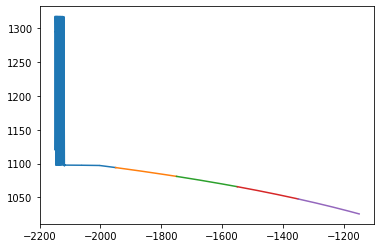

In [6]:
%matplotlib inline
time_idx = 1263
for dom_idx in range(5):
  x, p0 = mdtools.downsample(solver1D_par(dom_idx,time_idx), "pDensityC")
  plt.plot(x.ravel(), p0.ravel())
# Check p_ref
print(f"t = {solver1D_par(0,time_idx).time}")
solver1D_from(0).physics.IC.f.mixture.magma.p_ref

In [16]:
%matplotlib tk
mdtools.viz(solver2D_par(0,5), "Pressure")
mdtools.viz(solver2D_par(1,5), "Pressure")

5000000.0

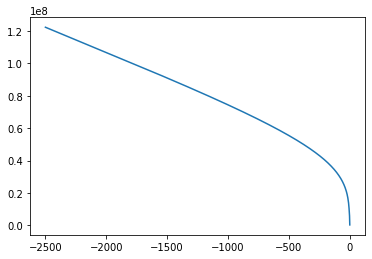

In [11]:
%matplotlib inline
x, p0 = mdtools.downsample(solver1D_from(0), "Pressure")
plt.plot(x.ravel(), p0.ravel())
# Check p_ref
solver1D_from(0).physics.IC.f.mixture.magma.p_ref

In [436]:
i = 0
solver1D_from(i).physics.BCs

{'x1': <physics.multiphasevpT.functions.VelocityInlet1D at 0x24eba2c0400>,
 'x2': <physics.multiphasevpT.functions.PressureOutlet1D at 0x24eba2c01c0>}

In [437]:
solb = solver1D_from(i).physics.Solubility
_k, _n = solb["k"], solb["n"]

q0 = solver1D_from(0).state_coeffs
_rho = q0[:,:,0:3].sum(axis=-1, keepdims=True)
yA = q0[:,:,0:1] / _rho
yWv = q0[:,:,1:2] / _rho
yM = q0[:,:,2:3] / _rho
yWt = q0[:,:,5:6] / _rho
yC = q0[:,:,6:7] / _rho
yL = 1.0 - yA - yWt - yC

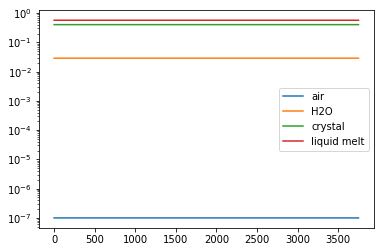

In [438]:
plt.semilogy(yA.ravel())
plt.semilogy(yWt.ravel())
plt.semilogy(yC.ravel())
plt.semilogy(yL.ravel())
plt.legend(["air", "H2O", "crystal", "liquid melt"])

In [439]:
p_sat = yWt / yL / _k ** (1/_n)
p_sat[0,0]

array([2.022000355516731e+09])

In [412]:
# solver1D_from(4).physics.compute_variable("phi", solver1D_from(4).state_coeffs)

In [440]:
solver = solver1D_from(2)
x = solver.elem_helpers.x_elems

In [441]:
%matplotlib tk
p0 = solver1D_from(0).physics.compute_variable("Pressure", solver1D_from(0).state_coeffs)
solver = solver1D_from(50)
print(solver.time)
p = solver.physics.compute_variable("Pressure", solver.state_coeffs)
plt.figure(1)
plt.plot(x.ravel(), (p0).ravel(), 'k')
plt.plot(x[:,0,0].ravel(), p[:,0,:].ravel(), '.-')
plt.plot(x[:,1,0].ravel(), p[:,1,:].ravel(), '.-')

5.000000000000365


In [442]:
c = solver.physics.compute_variable("SoundSpeed", solver.state_coeffs)
plt.clf()
plt.plot(c.ravel())

In [443]:
p0 = solver1D_from(0).physics.compute_variable("Pressure", solver1D_from(0).state_coeffs)
solver = solver1D_from(2)
print(solver.time)
deltap = lambda i: \
  solver.physics.compute_variable("Pressure", solver1D_from(i).state_coeffs) - p0
plt.figure(2)
plt.plot(x.ravel(), deltap(2).ravel(), '.-')
# plt.plot(x.ravel(), deltap(10).ravel(), '.-')
# plt.plot(x.ravel(), deltap(40).ravel(), '.-')

0.20000000000000015


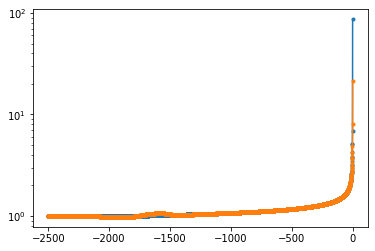

In [444]:
''' Velocity '''
%matplotlib inline
solver = solver1D_from(0)
plt.figure()
plt.semilogy(x.ravel(), solver.physics.compute_variable("Velocity", solver1D_from(0).state_coeffs).ravel(), '.-')
plt.semilogy(x.ravel(), solver.physics.compute_variable("Velocity", solver1D_from(2).state_coeffs).ravel(), '.-')
# plt.semilogy(x.ravel(), solver.physics.compute_variable("Velocity", solver1D_from(30).state_coeffs).ravel(), '.-')

In [445]:
%matplotlib tk
# Burgers-like equation
# d/dt (zeta) + (u+-c_0) d/dx (zeta) = +- (1/2) g / c_0
# Characteristic variable of mass-momentum equation for pure liquid
rho0 = solver.physics.Liquid["rho0"]
c0 = np.sqrt(solver.physics.Liquid["K"] / rho0)
dense_charvar = lambda rho, u: 0.5*(np.log(rho/rho0) + u / c0)
# From exact equation or integrating u +- dp / rho c_0
zeta_plus = lambda state_coeffs: dense_charvar(
  state_coeffs[...,0:3].sum(axis=-1, keepdims=True),
  solver.physics.compute_variable("XVelocity", state_coeffs))
zeta_minus = lambda state_coeffs: dense_charvar(
  state_coeffs[...,0:3].sum(axis=-1, keepdims=True), 
  -solver.physics.compute_variable("XVelocity", state_coeffs))

solver = solver1D_from(2)
rho = solver.state_coeffs[...,0:3].sum(axis=-1, keepdims=True)
u = solver.physics.compute_variable("XVelocity", solver.state_coeffs)

# Approximate (u+-c0) * dp/dx for hydrostatic gradient with
# c0 * dp/dx:
g = 9.8
hydroslope = -0.5 / (c0**2 / g)

plt.subplot(3,2,1)
plt.semilogy(x.ravel(), u.ravel())
plt.ylabel("u")
plt.subplot(3,2,2)
plt.semilogy(x.ravel(), rho.ravel() - rho0)
plt.ylabel("rho - rho0")
plt.subplot(3,2,3)
plt.semilogy(x.ravel(), dense_charvar(rho, u).ravel())
plt.semilogy(x.ravel(), (hydroslope*(x - x.min()) + dense_charvar(rho, u).ravel()[0]).ravel(), '--')
plt.ylabel("zeta+ characteristic var")
plt.legend(["zeta+", "approx hydrostatic part"])
plt.subplot(3,2,4)
plt.semilogy(x.ravel(), dense_charvar(rho, -u).ravel())
plt.semilogy(x.ravel(), (hydroslope*(x - x.min()) + dense_charvar(rho, -u).ravel()[0]).ravel(), '--')
plt.ylabel("zeta- characteristic var")
plt.legend(["zeta-", "approx hydrostatic part"])
plt.subplot(3,2,5)
plt.semilogy(x.ravel(), (u+c0).ravel())
plt.ylabel("u+c0")
plt.subplot(3,2,6)
plt.semilogy(x.ravel(), (c0-u).ravel())
plt.ylabel("-(u-c0)")

Text(0, 0.5, '-(u-c0)')

(250, 3, 1)

In [71]:
''' Plot composition-related '''

%matplotlib tk
solver = solver1D_par(0,4200)
# One-off load
# solver = readwritedatafiles.read_data_file("sherlock_par1D_osc_sub0_571.pkl")


x = solver.elem_helpers.x_elems
# solver = solver1D_from(600)
plt.figure(3, figsize=(12,6))
# plt.clf()
print(solver.time)
plt.subplot(1,3,1)
plt.title(f"{solver.time}")
rho = solver.state_coeffs[:,:,0:3].sum(axis=-1, keepdims=True)
yC = solver.state_coeffs[:,:,6:7]/rho
yWt = solver.state_coeffs[:,:,5:6]/rho
plt.plot(x.ravel(), yC.ravel(), '.-')
plt.ylabel("yC")
plt.subplot(1,3,2)
plt.plot(x.ravel(), yWt.ravel(), '.-')
plt.ylabel("yWt")
plt.subplot(1,3,3)
plt.plot(x.ravel(), rho.ravel(), '.-')
plt.ylabel("rho")

104.99999999794908


Text(0, 0.5, 'rho')

In [27]:
solver.elem_helpers.x_elems

array([[[-2149.9436491673105],
        [-2149.75           ],
        [-2149.5563508326895]],

       [[-2149.4436491673105],
        [-2149.25           ],
        [-2149.0563508326895]],

       [[-2148.9436491673105],
        [-2148.75           ],
        [-2148.5563508326895]],

       ...,

       [[-1951.4436491673105],
        [-1951.25           ],
        [-1951.0563508326895]],

       [[-1950.9436491673102],
        [-1950.75           ],
        [-1950.5563508326898]],

       [[-1950.4436491673105],
        [-1950.25           ],
        [-1950.0563508326895]]])

In [49]:
''' Plot shear-related '''

%matplotlib tk
solver = solver1D_par(0,900)
x = solver.elem_helpers.x_elems
# solver = solver1D_from(600)
plt.figure(3, figsize=(12,6))
# plt.clf()
print(solver.time)
plt.subplot(1,3,1)
rho = solver.state_coeffs[:,:,0:3].sum(axis=-1, keepdims=True)
u = solver.state_coeffs[:,:,3:4]/rho
plt.plot(x.ravel(), u.ravel(), '.-')

179.99999999747155


In [448]:
solver.state_coeffs[:,:,5:6]

array([[[79.58028851472591 ],
        [73.29531860172489 ],
        [66.92204840122363 ]],

       [[66.92096733896145 ],
        [73.0936332358787  ],
        [79.54627287163122 ]],

       [[79.54733449399677 ],
        [73.52016052399016 ],
        [66.91945041529056 ]],

       ...,

       [[26.334304039760372],
        [24.44535321392244 ],
        [22.27562443172426 ]],

       [[22.2876456495843  ],
        [19.653447332839104],
        [16.552253816502446]],

       [[16.402333070964556],
        [11.644277234434393],
        [ 0.880779966756969]]])

In [449]:
plt.clf()
plt.plot(x.ravel(), solver.physics.compute_variable("Pressure", solver1D_from(i).state_coeffs).ravel(), '.-')

ValueError: operands could not be broadcast together with shapes (1250,2,1) (1250,3,1) 

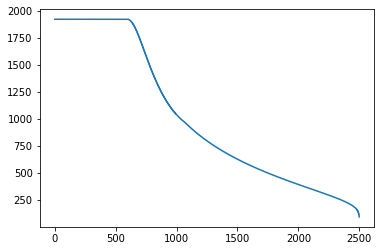

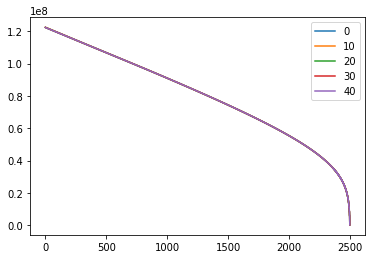

<Figure size 432x288 with 0 Axes>

In [20]:
''' Plot waves '''
%matplotlib inline
plt.figure()
plt.plot(mdtools.downsample(solver1D_from(0), "SoundSpeed")[1].ravel())
imax = 25
istep = 5
plt.figure()
for i in range(0, imax, istep):
  p = mdtools.downsample(solver1D_from(i), "Pressure")[1]
  plt.plot(p.ravel())
plt.legend(range(0, 90, 10))

plt.figure()
for i in range(0, imax, istep):
  c = mdtools.downsample(solver1D_from(i), "SoundSpeed")[1]
  p = mdtools.downsample(solver1D_from(i), "Pressure")[1]
  w = p + c*solver1D_from(i).state_coeffs[...,3:4]
  plt.plot(w.ravel())
plt.legend(range(0, imax, istep))

plt.figure()
for i in range(0, imax, istep):
  c = mdtools.downsample(solver1D_from(i), "SoundSpeed")[1]
  p = mdtools.downsample(solver1D_from(i), "Pressure")[1]
  w = p - c*solver1D_from(i).state_coeffs[...,3:4]
  plt.plot(w.ravel())
plt.legend(range(0, imax, istep))

0


Text(0, 0.5, 'pressure')

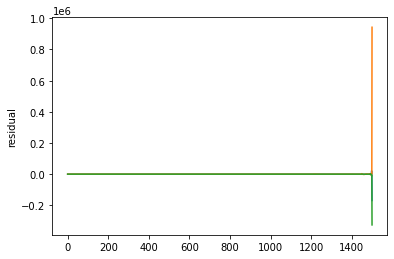

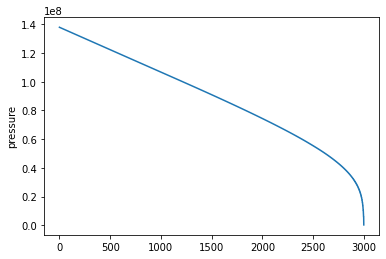

In [424]:
''' Plot residual '''
%matplotlib inline
print(i)
U = solver1D_from(i).state_coeffs
res = np.zeros_like(U)
solver1D_from(i).get_residual(U, res)
plt.plot(res[...,3])
plt.ylabel("residual")
plt.figure()
plt.plot(mdtools.downsample(solver1D_from(i), "Pressure")[1].ravel())
plt.ylabel("pressure")


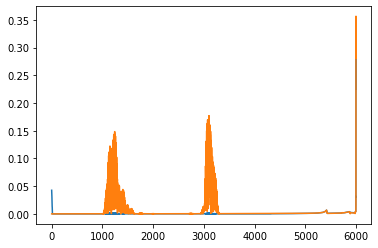

In [512]:
''' Pressure gradient computation '''
# Unpack
solver = solver1D_from(i)
physics = solver.physics
elem_helpers = solver.elem_helpers
quad_wts = elem_helpers.quad_wts # [nq, 1]
basis_phys_grad_elems = elem_helpers.basis_phys_grad_elems
    # [ne, nq, nb, dim]
basis_val = elem_helpers.basis_val # [nq, nb]
djac_elems = elem_helpers.djac_elems # [ne, nq, 1]
vol_elems = elem_helpers.vol_elems # [ne]
ndims = basis_phys_grad_elems.shape[3]

# Evaluate solution at quadrature points
Uq = helpers.evaluate_state(solver.state_coeffs, basis_val)
# Evaluate solution gradient at quadrature points
grad_Uq = np.einsum('ijnl, ink -> ijkl', basis_phys_grad_elems, solver.state_coeffs)
pressure = physics.compute_additional_variable("Pressure", Uq,
			flag_non_physical=False)[:, :, 0]
pgrad = physics.compute_pressure_gradient(Uq, grad_Uq)
f1 = np.linalg.norm(grad_Uq[:, :, 0], axis=2) / (Uq[:, :, 0] + 1e-12)
f2 = np.linalg.norm(pgrad, axis=2) / (pressure + 1e-12)
plt.plot(f1.ravel())
plt.plot(f2.ravel())

In [514]:
solver.order

1

In [516]:
# Compute s_k
p = solver.order
av_param = 500
s = np.zeros((solver.state_coeffs.shape[0], ndims))
# Loop over dimensions
for k in range(ndims):
  # Loop over number of faces per element
  for i in range(elem_helpers.normals_elems.shape[1]):
    # Integrate normals
    s[:, k] += np.einsum('jx, ij -> i', elem_helpers.face_quad_wts,
        np.abs(elem_helpers.normals_elems[:, i, :, k]))
  s[:, k] = 2 * vol_elems / s[:, k]
# Compute h_k (the length scale in the kth direction)
h = np.empty_like(s)
# Loop over dimensions
for k in range(ndims):
  h[:, k] = s[:, k] * (vol_elems / np.prod(s, axis=1))**(1/3) # TODO: Check 1/3 for ndims == 2. For ndims == 1, s==2V/2==V so pow (1/3) does nothing
# Scale with polynomial order
h_tilde = h / (p + 1)
# Compute dissipation scaling
epsilon = av_param *  np.einsum('ij, il -> ijl', f1 + f2, h_tilde**3)
# Calculate integral, with state coeffs factored out
integral = np.einsum('ijm, ijpm, ijnm, jx, ijx -> ipn', epsilon,
      basis_phys_grad_elems, basis_phys_grad_elems, quad_wts,
      djac_elems)
# Calculate residual
res_elem = np.einsum('ipn, ipk -> ink', integral, solver.state_coeffs)

Text(0.5, 0, 'Depth / m')

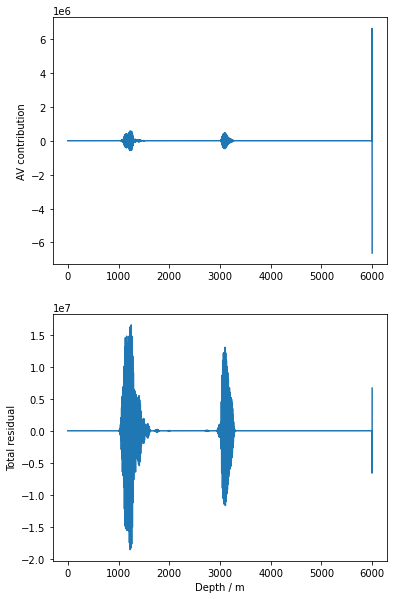

In [524]:
plt.figure(figsize=(6,10))
plt.subplot(2,1,1)
plt.plot(-res_elem[...,3].ravel())
plt.ylabel("AV contribution")


# Total residual
res = np.zeros_like(U)
solver1D_from(i).get_residual(U, res)
plt.subplot(2,1,2)
plt.plot((res+res_elem)[...,3].ravel())
plt.ylabel("Total residual")
plt.xlabel("Depth / m")

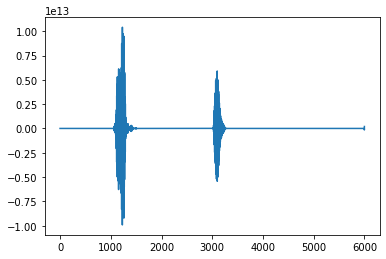

In [544]:
plt.plot((res_elem[...,3]*res[...,3]).ravel())

In [477]:
x, _ = mdtools.downsample(solver1D_from(i), "XVelocity")

In [478]:
np.sqrt(f.mixture.magma.K / f.mixture.magma.rho0)

1924.5008972987525

0.02000000000000006
0.11999999999999494
0.21999999999998393
0.3199999999999729
0.4199999999999619
0.519999999999951
0.6199999999999399
0.7199999999999289
0.8199999999999179
0.9199999999999069
1.0199999999999403
1.1200000000001513
1.2200000000003624


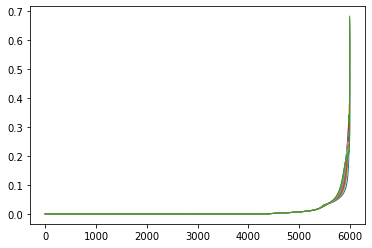

In [489]:
%matplotlib inline
# p0 = mdtools.downsample(solver1D_from(0), "Pressure")[1]
M_ = lambda i: (mdtools.downsample(solver1D_from(i), "XVelocity")[1]/
  mdtools.downsample(solver1D_from(i), "SoundSpeed")[1]).ravel()

for i in range(1,65,5):
  print(solver1D_from(i).time)
  plt.plot(M_(i), linewidth=1)

0.02000000000000006
0.11999999999999494
0.21999999999998393
0.3199999999999729
0.4199999999999619
0.519999999999951
0.6199999999999399
0.7199999999999289
0.8199999999999179
0.9199999999999069
1.0199999999999403
1.1200000000001513
1.2200000000003624


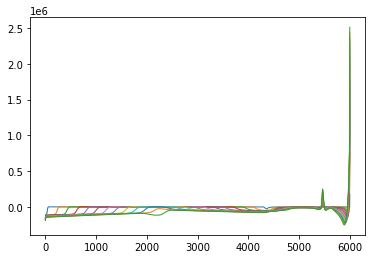

In [484]:
%matplotlib inline
p0 = mdtools.downsample(solver1D_from(0), "Pressure")[1]
deltap = lambda i: (mdtools.downsample(solver1D_from(i), "Pressure")[1] - p0).ravel()

for i in range(1,65,5):
  print(solver1D_from(i).time)
  plt.plot(deltap(i), linewidth=1)

In [430]:
solver1D_from(5).physics.source_terms[3].tau_f

10.0

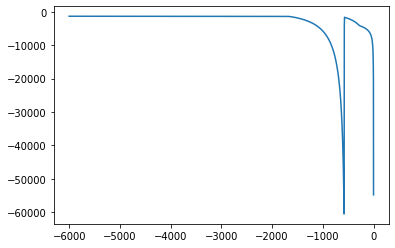

In [371]:
i = 0
L = solver1D_from(i).physics.source_terms[1].get_source(
  solver1D_from(i).physics, solver1D_from(i).state_coeffs, x, None,
)
plt.plot(x.ravel(), L[...,3].ravel())

In [446]:
fsource = solver1D_from(i).physics.source_terms[1]

fsource.get_source(
    solver1D_from(i).physics, solver1D_from(i).state_coeffs, x, None,
  )
fsource.compute_viscosity(solver1D_from(i).state_coeffs, solver1D_from(i).physics)

array([[[  347031.20061454957],
        [  382922.8153928215 ]],

       [[  383200.6521631435 ],
        [  411015.1841422915 ]],

       [[  411108.3513920274 ],
        [  422843.3461433982 ]],

       ...,

       [[10741653.381455228  ],
        [10741655.95779703   ]],

       [[10741654.512755264  ],
        [10741680.344079213  ]],

       [[10741686.860622857  ],
        [10741689.96793804   ]]])

In [462]:
%matplotlib tk
plt.figure(2)
# plt.plot(fsource.compute_viscosity(solver1D_from(i).state_coeffs, solver1D_from(i).physics).ravel())
drag = solver1D_from(i).physics.source_terms[0].get_source(
    solver1D_from(i).physics, solver1D_from(i).state_coeffs, x, None,
  )[...,4]
dragrate = drag/solver1D_from(i).state_coeffs[...,4]
# plt.plot(drag.ravel(), '.-')
plt.plot(solver1D_from(i).state_coeffs[...,3].ravel(), '.-')

In [459]:
solver1D_from(i).physics.source_terms[0]

In [485]:
%matplotlib tk
# plt.figure()
plt.figure(figsize=(12,5))
for i in range(0,16,5):
  U = solver1D_from(i).state_coeffs
  rho = U[:,:,0:3].sum(axis=-1, keepdims=True)
  yWt = U[:,:,5:6]/rho
  u = mdtools.downsample(solver1D_from(i), "XVelocity")[1]
  j = rho*u
  # plt.plot(U[:,:,4:5].ravel())

  L = solver1D_from(i).physics.source_terms[1].get_source(
    solver1D_from(i).physics, solver1D_from(i).state_coeffs, x, None,
  )
  plt.plot(L.ravel(), '.-')

  # q = mdtools.downsample(solver1D_from(i), "XVelocity")[1]
  # plt.plot(rho.ravel())
  # plt.plot(u.ravel())


In [201]:
x, p0 = mdtools.downsample(solver1D_from(0), "Pressure")

In [202]:
x_phy = np.unique(x)
outs = solver1D_from(0).physics.IC.f(x_phy, True)

In [203]:
solver1D_from(0).physics.Liquid, \
  (solver1D_from(0).physics.IC.f.mixture.magma.K,
  solver1D_from(0).physics.IC.f.mixture.magma.rho0,
  solver1D_from(0).physics.IC.f.mixture.magma.p_ref,
  solver1D_from(0).physics.IC.f.mixture.magma.c_v)

({'K': 10000000000.0,
  'rho0': 2700.0,
  'p0': 5000000.0,
  'E_m0': 0,
  'c_m': 3000.0},
 (10000000000.0, 2700.0, 10000000.0, 3000.0))

In [486]:
solver1D_from(0).physics.IC.f.mixture.magma.p_ref = 5e6
solver1D_from(0).physics.IC.f._set_cache(1e5, 1.0, "u")
q1_fixed = solver1D_from(0).physics.IC.f(x_phy, True)
plt.plot(x_phy, q1_fixed[0,:])
plt.plot(x.ravel(), mdtools.downsample(solver1D_from(0), "Pressure")[1].ravel(), '.')
plt.legend(["Native phyy", "Quail"])

Computing minimum possible pressure.
Minimum vent pressure is 287513.4485509206.
Choked flow.


ValueError: x and y must have same first dimension, but have shapes (3001,) and (3000,)

In [42]:
outs.shape

(3, 3000)

In [12]:
x.shape

(3000, 2, 1)

In [23]:
import compressible_conduit_steady.steady_state
U1_fixed = solver1D_from(0).physics.IC.f(np.unique(x))


In [22]:
x_phy.shape, x.shape

((3001,), (3000, 2, 1))

In [24]:
np.expand_dims(U1_fixed, axis=1).shape

(3001, 1, 8)

In [25]:
U1_fixed.shape
U2 = np.zeros((U1_fixed.shape[0]-1, 1, U1_fixed.shape[1]))
U2.shape
U2[:] = np.expand_dims(U1_fixed, axis=1)[:-1,...]


In [26]:
p_ = solver1D_from(0).physics.compute_additional_variable("Pressure", U2, False)

In [211]:
state_name = "Pressure"

x, pQ = mdtools.downsample(solver1D_from(0), state_name)
x, hvolQ = mdtools.downsample(solver1D_from(0), "Enthalpy")
UQ = solver1D_from(0).state_coeffs
rhoQ = UQ[...,0:3].sum(axis=-1, keepdims=True)
Y_awm = UQ[...,0:3]/rhoQ
Y_wt = UQ[...,5:6]/rhoQ
hspec = hvolQ / rhoQ
# More quantities
_, phiQ = mdtools.downsample(solver1D_from(0), "phi")
_, TQ = mdtools.downsample(solver1D_from(0), "Temperature")
# _, phiQ = mdtools.downsample(solver1D_from(0), "phi")

In [46]:
p_phy.shape

(3000,)

In [213]:
# Unpack native phy
p_phy, h_phy, y_phy, yF_phy = outs
f = solver1D_from(0).physics.IC.f

from types import SimpleNamespace
odenative = SimpleNamespace(**{
  "p": p_phy,
  "h": h_phy,
  "y": y_phy,
  "yF": yF_phy,
})

In [214]:
odenative.T = f.T_ph(odenative.p, odenative.h, odenative.y)
odenative.vf_g = f.vf_g(odenative.p, odenative.T, odenative.y)
odenative.parvol_m = (1-odenative.y) * f.mixture.magma.v_pT(odenative.p, odenative.T)
odenative.parvol_wv = odenative.y * f.mixture.waterEx.v_pT(odenative.p, odenative.T)
odenative.e_edf = f.mixture.magma.e_dfm(odenative.p)

In [57]:
# defo = f.mixture.magma.e_dfm(pQ)
# T_phy = f.mixture.T_ph(p_phy, h_phy)
# phi_phy = f.vf_g(p, T, y)

In [243]:
f = solver1D_from(0).physics.IC.f

In [244]:
f.mixture.magma.p_ref

10000000.0

In [216]:
h_sample = odenative.h[0]
print(f"Native: h = {h_sample}")
# p, h, y -> cons
rho = 1 / f.v_mix(odenative.p[0], odenative.h[0], odenative.y[0])
print(f"Native density = {rho}")
print(f"Native energy = {odenative.h[0] - odenative.p[0]/rho}")
print(f"Native p = {odenative.p[0]}")
print(f"Native T = {f.T_ph(odenative.p[0], odenative.h[0], odenative.y[0])}")
e_vol = rho * (odenative.h[0] - odenative.p[0] / rho) + 0.5 * f.j0**2 / rho
U_sample = np.array([f.yA*rho, odenative.y[0]*rho, (1-f.yA-odenative.y[0])*rho,
  f.j0, e_vol, f.yWt*rho, f.yC*rho, 0])
# Remap
Et_recons = U_sample[...,4:5]
E_recons = solver1D_from(0).physics.compute_variable("InternalEnergy", np.expand_dims(U_sample,axis=(0,1)))
rho_recons = U_sample[...,0:3].sum(axis=-1, keepdims=True)
p_recons = solver1D_from(0).physics.compute_variable("Pressure", np.expand_dims(U_sample,axis=(0,1)))
T_recons = solver1D_from(0).physics.compute_variable("Temperature", np.expand_dims(U_sample,axis=(0,1)))
print(f"Quail e_tot = {Et_recons/rho_recons}")
print(f"Quail e = {E_recons/rho_recons}")
print(f"Quail density = {rho_recons}")
print(f"Quail pressure = {p_recons}")
print(f"Quail temperature = {T_recons}")

Native: h = 3248186.393718305
Native density = 1780.632908406347
Native energy = 3204471.977277096
Native p = 77839328.48699613
Native T = 1073.1500000000003
Quail e_tot = [3204473.1421508775]
Quail e = [[[3204471.9772770954]]]
Quail density = [1780.6329084063473]
Quail pressure = [[[25956.423639297485]]]
Quail temperature = [[[1068.1615848797703]]]


In [232]:
f.v_mix(odenative.p[0], odenative.h[0], 0.0), \
  f.mixture.v_mix(odenative.p[0], f.T_ph(odenative.p[0], odenative.h[0], odenative.y[0]), f.yA, 0.0, 1.0-f.yA), \
  f.mixture.magma.v_pT(odenative.p[0], f.T_ph(odenative.p[0], odenative.h[0], odenative.y[0])), \
  f.mixture.magma.v_pT(odenative.p[0], None)

(0.000369072329111189,
 0.0003678750917774897,
 0.0003678747328857402,
 0.0003678747328857402)

In [241]:
f.mixture.magma.K / physics.Liquid["K"], \
  f.mixture.magma.rho0 / physics.Liquid["rho0"], \
  f.mixture.magma.p_ref / physics.Liquid["p0"]

(1.0, 1.0, 2.0)

In [233]:
rho_m_assay = (1 + (odenative.p[0] - physics.Liquid["p0"]) / physics.Liquid["K"]) * physics.Liquid["rho0"]
1 / rho_m_assay * (1.0-f.yA), 1 / rho_m_assay

(0.00036769208884915804, 0.0003676921256183706)

In [217]:
f.mixture.magma.p_ref, physics.Liquid["p0"]
# dir(f.mixture.air)
f.mixture.air.R, f.mixture.air.c_v, f.mixture.air.c_p, f.mixture.air.gamma, \
  physics.Gas[0]
f.mixture.waterEx.R, f.mixture.waterEx.c_v, f.mixture.waterEx.c_p, f.mixture.waterEx.gamma, \
  physics.Gas[1]
f.mixture.magma.K, f.mixture.magma.rho0, f.mixture.magma.c_v, f.mixture.magma.p_ref, physics.Liquid


(10000000000.0,
 2700.0,
 3000.0,
 10000000.0,
 {'K': 10000000000.0,
  'rho0': 2700.0,
  'p0': 5000000.0,
  'E_m0': 0,
  'c_m': 3000.0})

In [218]:
phi = solver1D_from(0).physics.compute_variable("phi", np.expand_dims(U_sample,axis=(0,1)))
phi

array([[[0.340184796148306]]])

In [219]:
physics = solver1D_from(0).physics
rho_m = U_sample[...,2]/(1 - phi)
p_m = (rho_m - physics.Liquid["rho0"]) * physics.Liquid["K"] / physics.Liquid["rho0"] + physics.Liquid["p0"]

# Sum partial pressures
p_gas = (U_sample[...,0] * physics.Gas[0]["R"] * T_recons \
  + U_sample[...,1] * physics.Gas[1]["R"] * T_recons) / phi

# rho_a = U_sample[...,0]
p_m, p_gas

(array([[[25956.423638422973]]]), array([[[25956.42363872625]]]))

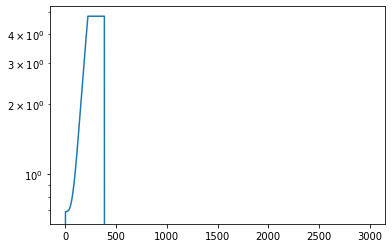

In [123]:
# Constraint violation
# plt.semilogy(odenative.y)
plt.semilogy(-odenative.y * 3e3 * 1000) # approx [[y]] * c_m * T

In [58]:
pQ.shape, defo.shape

((3000, 2, 1), (3000, 2, 1))

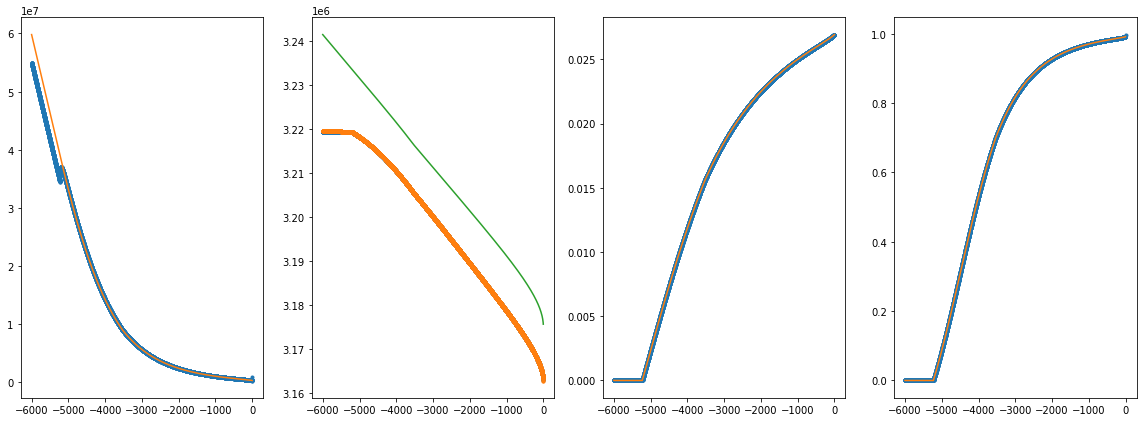

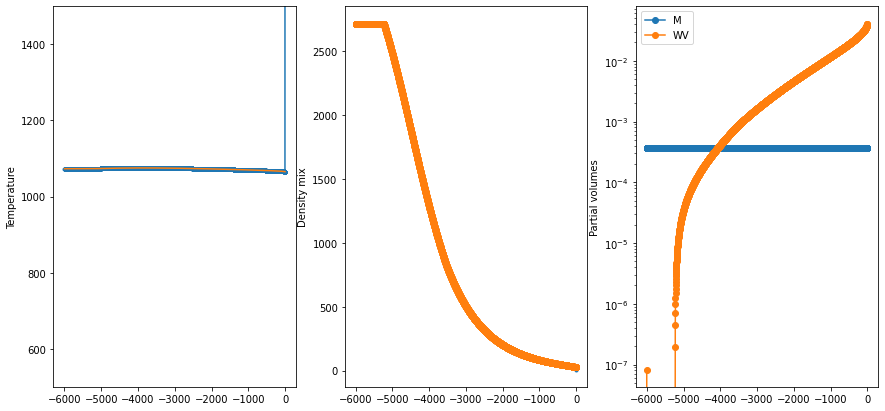

In [116]:
plt.figure(figsize=(20,7))
plt.subplot(1,4,1)
plt.plot(x.ravel(), pQ.ravel(), '.-')
# plt.plot(x_phy[:-1], outs[0,:])
plt.plot(x_phy[:-1], odenative.p)

plt.subplot(1,4,2)
plt.plot(x.ravel()[:-1], hspec.ravel()[:-1], '.-')
plt.plot(x.ravel()[:-1], (hspec + defo).ravel()[:-1], '.-')
# plt.plot(x_phy[:-1], outs[0,:])
plt.plot(x_phy[:-1], odenative.h)

plt.subplot(1,4,3)
plt.plot(x.ravel()[:-1], Y_awm[...,1].ravel()[:-1], '.-')
# plt.plot(x_phy[:-1], outs[0,:])
plt.plot(x_phy[:-1], odenative.y), 'o-'

plt.subplot(1,4,4)
plt.plot(x.ravel(), phiQ.ravel(), '.-')
# plt.plot(x_phy[:-1], q1_fixed[0,:])
plt.plot(x_phy[:-1], odenative.vf_g), 'o-'

plt.figure(figsize=(20,7))
plt.subplot(1,4,1)
# TODO: boundary fix needed
plt.plot(x.ravel(), TQ.ravel(), '.-')
plt.plot(x_phy[:-1], odenative.T), 'o-'
plt.ylim((500,1500))
plt.ylabel("Temperature")

odenative.rho = 1/odenative.parvol_m + 1/odenative.parvol_wv
odenative.v_corrected = np.clip(1-odenative.y,0, 1) * f.mixture.magma.v_pT(odenative.p, odenative.T) \
  + np.clip(odenative.y,0, 1) * f.mixture.waterEx.v_pT(odenative.p, odenative.T)
odenative.rho_corected = 1.0 / odenative.v_corrected
plt.subplot(1,4,2)
plt.plot(x.ravel(), rhoQ.ravel(), '.-')
# plt.plot(x_phy[:-1], odenative.rho, 'o-')
plt.plot(x_phy[:-1], odenative.rho_corected, 'o-')
plt.ylabel("Density mix")

plt.subplot(1,4,3)
plt.semilogy(x_phy[:-1], odenative.parvol_m, 'o-')
plt.semilogy(x_phy[:-1], odenative.parvol_wv, 'o-')
plt.ylabel("Partial volumes")
plt.legend(["M", "WV"])

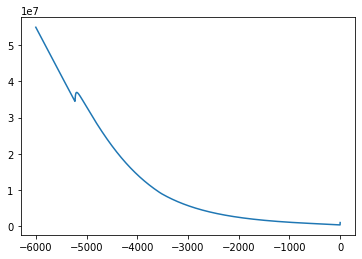

In [32]:
x, p0 = mdtools.downsample(solver1D_from(0), "Pressure")
plt.plot(x.ravel(), p0.ravel())

In [902]:
x, u = mdtools.downsample(solver, "XVelocity")
_, c = mdtools.downsample(solver, "SoundSpeed")
_, p = mdtools.downsample(solver, "Pressure")
_, phi = mdtools.downsample(solver, "phi")
_, T = mdtools.downsample(solver, "Temperature")
_, Gamma = mdtools.downsample(solver, "Gamma")

In [903]:
# solver.state_coeffs[...,-3]

In [904]:
# Secondary computations
rho    = solver.state_coeffs[...,0:3].sum(axis=-1, keepdims=True)
arhoWt = solver.state_coeffs[...,-3:-2]
yWt = arhoWt / rho
yWv = solver.state_coeffs[...,1:2] / rho
yM  = solver.state_coeffs[...,2:3] / rho
sRatio = T ** Gamma / p ** (Gamma-1)
# Soluble concentration
xd = solver.physics.Solubility["k"] * p ** solver.physics.Solubility["n"]

In [905]:
solver.physics.source_terms[1].crit_volfrac

0.8

In [906]:
atomics.mixture_density(np.array([[[0,0,1]]]),2e8 - 9.8*2.6e3*4500, 300, solver.physics)

array([[[2721.6918]]])

In [907]:
phi.shape

(3000, 2, 1)

Text(0, 0.5, 'sRatio')

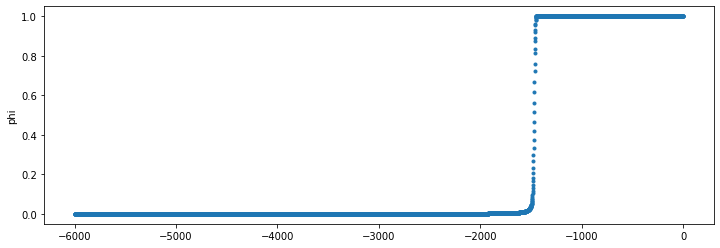

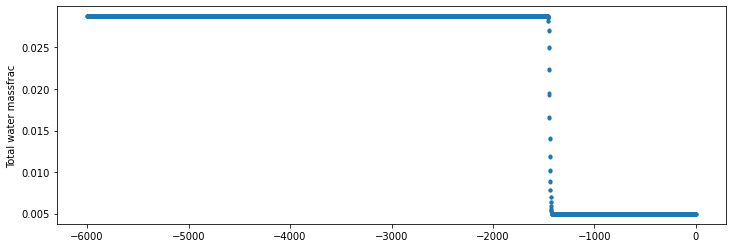

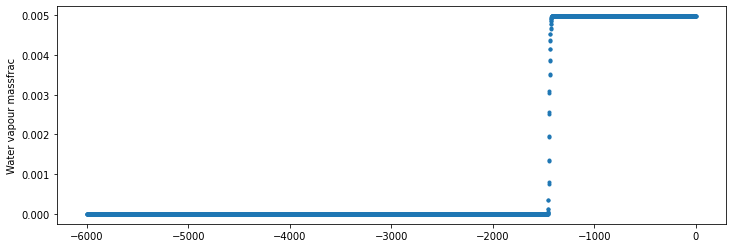

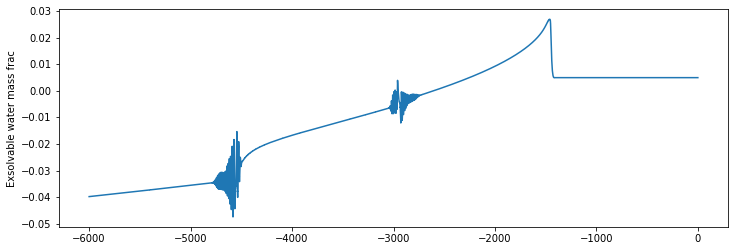

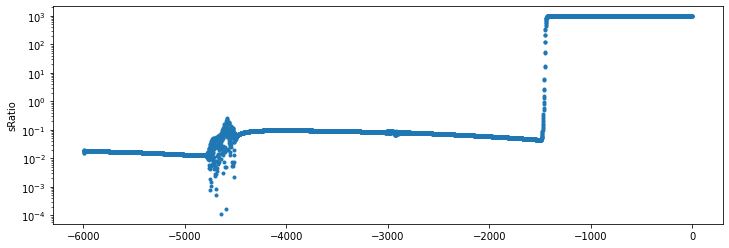

In [908]:
plt.figure(figsize=(12,4))
plt.plot(x.ravel(), phi.ravel(), '.'); plt.ylabel("phi")
plt.figure(figsize=(12,4))
plt.plot(x.ravel(), yWt.ravel(), '.'); plt.ylabel("Total water massfrac")
plt.figure(figsize=(12,4))
plt.plot(x.ravel(), yWv.ravel(), '.'); plt.ylabel("Water vapour massfrac")
plt.figure(figsize=(12,4))
plt.plot(x.ravel(), (yWt-(xd/(1+xd))*yM).ravel(), '-'); plt.ylabel("Exsolvable water mass frac")
plt.figure(figsize=(12,4))
plt.semilogy(x.ravel(), np.abs(sRatio-sRatio[0,0,0]).ravel(), '.'); plt.ylabel("sRatio")

In [453]:
f"Approx rate: {(1e7 / 2.7e3) * 8 / 50*2}"

'Approx rate: 1185.1851851851852'

(1500.0, 2034.24868944663)

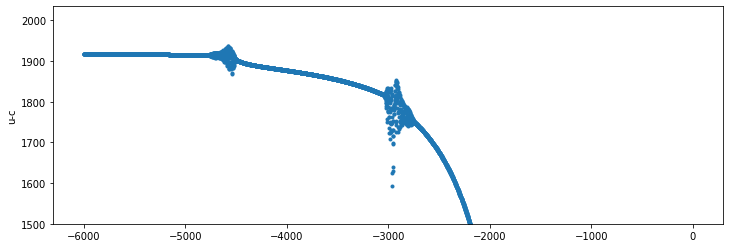

In [909]:
plt.figure(figsize=(12,4))
plt.plot(x.ravel(), np.abs(u-c).ravel(), '.'); plt.ylabel("u-c")
plt.ylim(bottom=1.5e3)

(-2000.0, -1500.0)

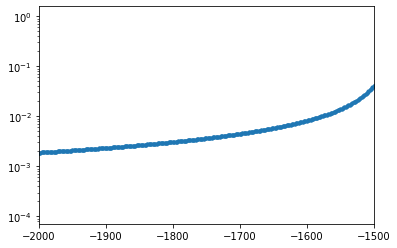

In [910]:
plt.semilogy(x.ravel(), np.abs(phi).ravel(), '.'); plt.xlim((-2000,-1500))

In [819]:
np.sqrt(solver.physics.Liquid["K"] / solver.physics.Liquid["rho0"])

1924.5008972987525

In [912]:
solver.physics.source_terms

Text(0, 0.5, 'p')

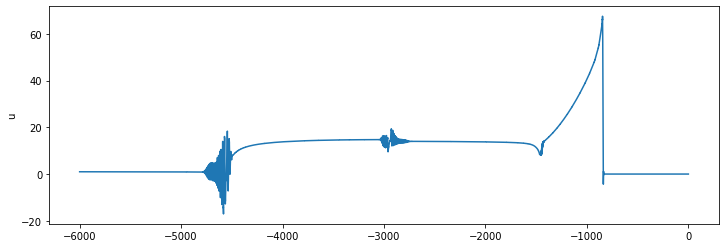

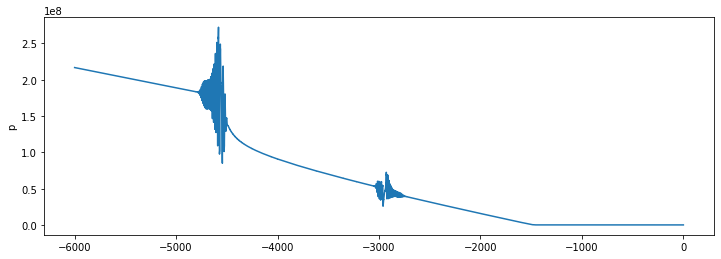

In [911]:
plt.figure(figsize=(12,4))
plt.plot(x.ravel(), u.ravel(), '-'); plt.ylabel("u")
plt.figure(figsize=(12,4))
plt.plot(x.ravel(), p.ravel(), '-'); plt.ylabel("p")

1920.6315525692573

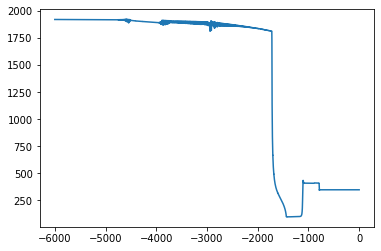

In [835]:
plt.plot(x.ravel(), c.ravel())
c.max()

In [833]:
_c = solver1D_from(64).physics.compute_additional_variable("SoundSpeed", solver1D_fromAV(64).state_coeffs, False)

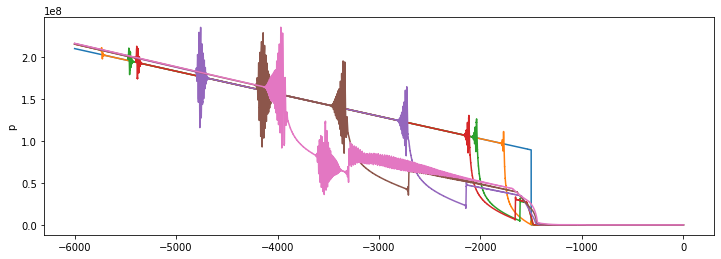

In [836]:
plt.figure(figsize=(12,4))
plt.plot(x.ravel(), mdtools.downsample(solver1D_from(0), "Pressure")[1].ravel(), '-')
plt.ylabel("p")
plt.plot(x.ravel(), mdtools.downsample(solver1D_from(7), "Pressure")[1].ravel(), '-')
plt.plot(x.ravel(), mdtools.downsample(solver1D_from(14), "Pressure")[1].ravel(), '-')

plt.plot(x.ravel(), mdtools.downsample(solver1D_from(16), "Pressure")[1].ravel(), '-')
plt.plot(x.ravel(), mdtools.downsample(solver1D_from(32), "Pressure")[1].ravel(), '-')
plt.plot(x.ravel(), mdtools.downsample(solver1D_from(48), "Pressure")[1].ravel(), '-')
plt.plot(x.ravel(), mdtools.downsample(solver1D_from(64), "Pressure")[1].ravel(), '-')

In [696]:
solver1D_from(16).state_coeffs.shape

(3000, 2, 8)

In [691]:
q = solver1D_from(1).state_coeffs[:,:,0]
q.mean(axis=1).ravel().shape

(3000,)

(1e-07, 1000.0)

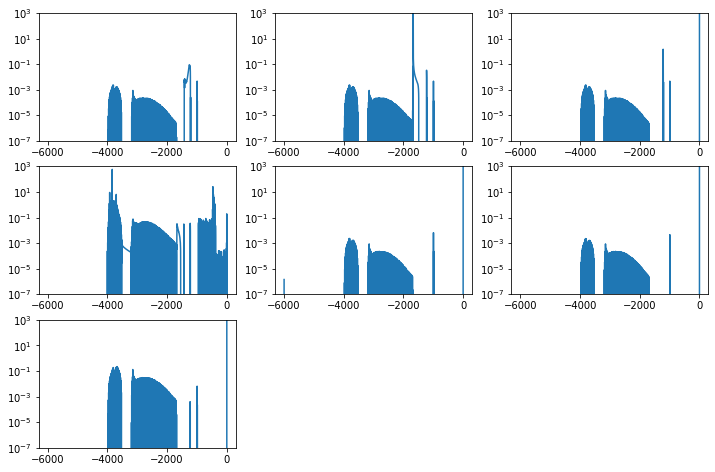

In [716]:
ddx_approx = lambda q: (1/2)*(np.diff(q.mean(axis=1).ravel(), append=q.mean(axis=1).ravel()[0]) / q.mean(axis=1).ravel())
plt.figure(figsize=(12,8))
for state_idx in range(6):
  plt.subplot(3,3,state_idx+1)
  plt.semilogy(x.mean(axis=1).ravel(), ddx_approx(solver1D_from(60).state_coeffs[:,:,state_idx]))
  plt.ylim((1e-7, 1e3))
# plt.legend(range(6), loc="best")

plt.subplot(3,3,7)
get_p = lambda U: solver1D_from(60).physics.compute_additional_variable("Pressure", U, False)
plt.semilogy(x.mean(axis=1).ravel(), ddx_approx(get_p(solver1D_from(60).state_coeffs[:,:,:])))
plt.ylim((1e-7, 1e3))

In [686]:
solver1D_from(16).time

0.31999999999996886

C:\Users\Fredric\Documents\Volcano\quail_volcano\src\physics\multiphasevpT\functions.py:2347: RuntimeWarning: invalid value encountered in log
  physics.get_state_indices()


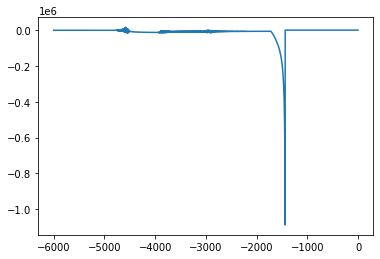

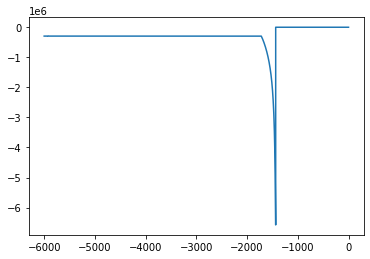

In [399]:
solver = solver1D_from(80)
solver.physics.source_terms[1].get_source(solver.physics, solver.state_coeffs, x, 000)
S = solver.physics.source_terms[1].get_source(solver.physics, solver.state_coeffs, x, 000)
u = solver.physics.compute_variable("XVelocity", solver.state_coeffs)

plt.plot(x.ravel(), S[...,3].ravel())
plt.figure()
_fric = S[...,3].ravel()
_p = mdtools.downsample(solver1D_from(80), "Pressure")[1].ravel()
plt.plot(x.ravel(), (_fric.ravel() / u.ravel()).ravel() / 8 * 50**2)
# plt.plot(x.ravel(), _p / _p.max())
# plt.xlim((-2000,-1000))


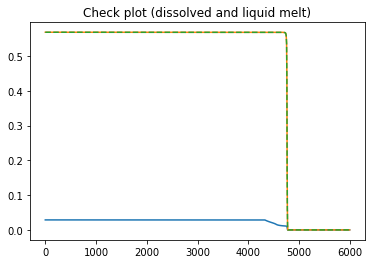

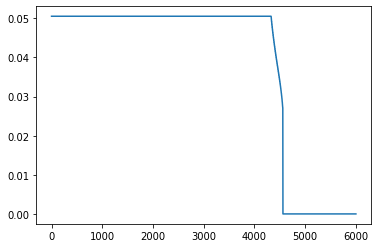

In [387]:
solver = solver1D_from(60)
rho = solver.state_coeffs[...,0:3].sum(axis=-1, keepdims=True)
ywt = solver.state_coeffs[...,5:6] / rho
ywv = solver.state_coeffs[...,1:2] / rho
ym = solver.state_coeffs[...,2:3] / rho
yc = solver.state_coeffs[...,6:7] / rho
ya = solver.state_coeffs[...,0:1] / rho
yd = ywt - ywv
yl = ym - yd - yc
phi = solver.physics.compute_variable("phi", solver.state_coeffs)
crit_volfrac = solver.physics.source_terms[1].crit_volfrac
T = solver.physics.compute_variable("Temperature", solver.state_coeffs)
plt.plot(yd.ravel())
plt.plot(yl.ravel())
plt.plot((1 - ywt - yc - ya).ravel(), '--')
plt.title("Check plot (dissolved and liquid melt)")
plt.figure()

mfWd = np.where(phi > crit_volfrac, 0, yd/yl)
# plt.plot((yd/yl).ravel())
plt.plot(mfWd.ravel())

C:\Users\Fredric\AppData\Local\Temp\ipykernel_86340\722075693.py:2: RuntimeWarning: divide by zero encountered in log10
  log_mfWd = np.log10(mfWd*100)
C:\Users\Fredric\AppData\Local\Temp\ipykernel_86340\722075693.py:3: RuntimeWarning: invalid value encountered in true_divide
  return 10**(-3.545 + 0.833 * log_mfWd + (9601 - 2368 * log_mfWd) / (temp - 195.7 - 32.25 * log_mfWd))


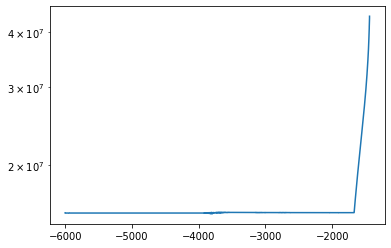

In [401]:
def mu_like(mfWd, temp):
  log_mfWd = np.log10(mfWd*100)
  return 10**(-3.545 + 0.833 * log_mfWd + (9601 - 2368 * log_mfWd) / (temp - 195.7 - 32.25 * log_mfWd))

plt.plot(x.ravel(), mu_like(mfWd, T).ravel())

In [413]:
np.where((mu_like(mfWd, T).ravel() > 1), mu_like(mfWd, T).ravel(), 9e9*np.ones_like(T.ravel())).min()

C:\Users\Fredric\AppData\Local\Temp\ipykernel_86340\722075693.py:2: RuntimeWarning: divide by zero encountered in log10
  log_mfWd = np.log10(mfWd*100)
C:\Users\Fredric\AppData\Local\Temp\ipykernel_86340\722075693.py:3: RuntimeWarning: invalid value encountered in true_divide
  return 10**(-3.545 + 0.833 * log_mfWd + (9601 - 2368 * log_mfWd) / (temp - 195.7 - 32.25 * log_mfWd))


15512177.862548288

(0.0, 300000000.0)

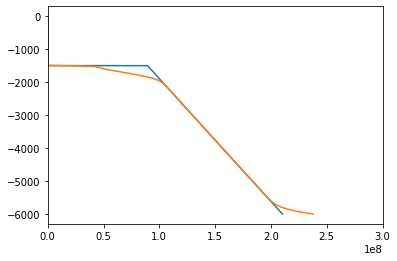

In [274]:
plt.plot(mdtools.downsample(solver1D_from(0), "Pressure")[1].ravel(), x.ravel(), '-')
plt.plot(mdtools.downsample(solver1D_from(16), "Pressure")[1].ravel(), x.ravel(), '-')
plt.xlim((0, 3e8))

In [119]:
np.expand_dims(np.array([-1,0]),axis=(0,1))

array([[[-1,  0]]])

In [122]:
mfinlet = solver.physics.BCs["x1"]
Ub = mfinlet.get_boundary_state(solver.physics, solver.state_coeffs[0:1,0:1,:], np.expand_dims(np.array([-1]),axis=(0,1)), 000, 000)
solver.physics.compute_variable("XVelocity", Ub)

array([[[1.016739023211737]]])

In [147]:
import physics.multiphasevpT.atomics as atomics
e = solver.physics.Liquid["c_m"] * 2608.686 * 1000
arhoVec = np.array([1e-1, 8.686, 2600])
mom = np.array([[[0]]])
# atomics.temperature(arhoVec, mom, e, solver.physics)
atomics.pressure(arhoVec, 1000, atomics.gas_volfrac(arhoVec, 1000, solver.physics), solver.physics)

array([4.911705376922283e+08])

In [168]:
actual_jump = np.abs(np.diff(p0.ravel())).max()
# Hydrostatic pressure of magma column 
p_hyd = np.max(p0.ravel()) - p0.ravel()[np.abs(np.diff(p0.ravel())).argmax()]
desired_jump = 2e8 - p_hyd

In [171]:
factor = desired_jump/actual_jump
factor

0.17054936309292384

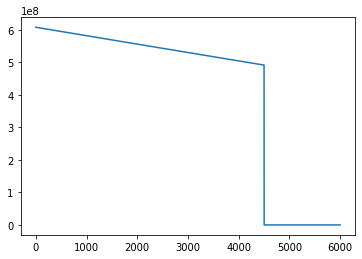

In [125]:
plt.plot(p0.ravel())

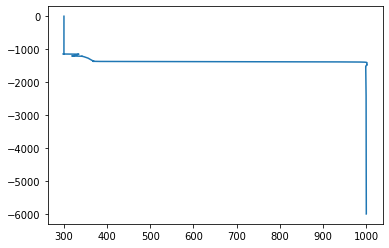

In [123]:
plt.plot(mdtools.downsample(solver1D_from(40), "Temperature")[1].ravel(), x.ravel(), '-')

Text(0, 0.5, 'Delta p')

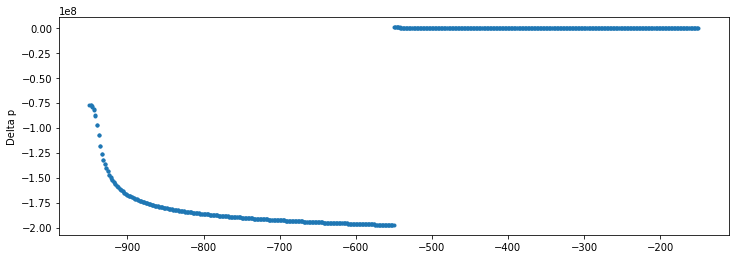

In [35]:
plt.figure(figsize=(12,4))
plt.plot(x.ravel(), (p-p0).ravel(), '.'); plt.ylabel("Delta p")
# plt.figure(figsize=(12,4))
# plt.plot(x.ravel(), p.ravel(), '.'); plt.ylabel("u")

In [117]:
#  'compute_indicator',
#  'compute_viscosity',
#  'conduit_radius',
#  'crit_volfrac',
#  'get_indicator_deriv',
#  'get_jacobian',
#  'get_phi_gradient',
#  'get_source',
#  'logistic_scale',
#  'source_treatment']

friction_term = solver.physics.source_terms[1]
# plt.semilogy(friction_term.compute_indicator(phi).ravel())
# plt.plot(friction_term.compute_viscosity(solver.state_coeffs, solver.physics).ravel())
# plt.plot(, '-')
# F = friction_term.get_source(solver.physics, solver.state_coeffs, 000, 000).ravel()
# x = np.array([solver.mesh.node_coords[0:-1,0], solver.mesh.node_coords[1:,0]]
# F.shape

(16000,)

In [127]:
''' Simulate .get_source '''
Uq = solver.state_coeffs
physics = solver.physics

if physics.NDIMS != 1:
  raise Exception(f"Conduit friction source not suitable for use in " +
                  f"{physics.NDIMS} spatial dimensions.")
iarhoA, iarhoWv, iarhoM, imom, ie, iarhoWt, iarhoC, iarhoFm = \
  physics.get_state_indices()

''' Compute mixture density, u, friction coefficient '''
rho = np.sum(Uq[:, :, physics.get_mass_slice()],axis=2,keepdims=True)
u = Uq[:, :, physics.get_momentum_slice()] / (rho + 1e-15)
mu = friction_term.compute_viscosity(Uq, physics)
fric_coeff = 8.0 * mu / friction_term.conduit_radius**2.0
''' Compute indicator based on magma porosity '''
#I = self.compute_indicator( \
#	physics.compute_additional_variable("phi", Uq, True))
''' Compute source vector at each element [ne, nq] '''
S = np.zeros_like(Uq)
S[:, :, physics.get_momentum_slice()] = -fric_coeff * u
S[:, :, physics.get_state_slice("Energy")] = -fric_coeff * u**2.0

mu = friction_term.compute_viscosity(solver.state_coeffs, solver.physics)

5e-05

In [169]:
# plt.figure(figsize=(12,4))
# plt.plot(S[:,:,3].ravel())
plt.figure(figsize=(12,4))
plt.plot(mu.ravel())

coeff = 8.0 * mu / friction_term.conduit_radius**2.0
# Plot friction coefficient
# plt.figure(figsize=(12,4))
# plt.plot(coeff.ravel())
# Plot source lambda
plt.figure(figsize=(12,4))
ll = coeff / rho
plt.plot(ll.ravel())
plt.ylabel("1/timescale of friction term (1/s)")
plt.title(f"Max supported rate 1/dt: {1/solver.stepper.dt}")

# Friction reaction plot
plt.figure(figsize=(12,4))
plt.plot(u.ravel(), S[:,:,3].ravel(), '.')
plt.xlim((-1,1))
plt.ylim((-2e5,2e5))
plt.xlabel("u")
plt.ylabel("drag term")
plt.grid("both")

array([3.])

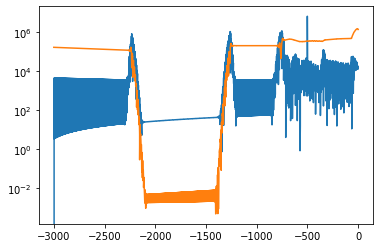

In [204]:
# d(Delta p)/dx removing hydrostatic
# plt.plot(x.ravel(), (p - p0).ravel())

semilogyabs = lambda dat: plt.semilogy(x.ravel(), np.abs(dat).ravel())


# Approximate dp/dx
dx = solver.mesh.node_coords[1] - solver.mesh.node_coords[0]
pdx_approx =  np.diff((p - p0).ravel(), prepend=(p-p0)[0,0]) / dx

# Compute gravity source
Sgrav = solver.physics.source_terms[0].get_source(solver.physics, solver.state_coeffs, 000, 000)

semilogyabs(pdx_approx)
semilogyabs(S[...,3])
# semilogyabs(Sgrav[...,3])

In [200]:
Sgrav[:,:,3].ravel()

array([-26910.31117181584 , -26910.06048930237 , -26910.060463256596, ...,
       -17184.358235029173, -16390.74406601727 , -13623.128676371585])

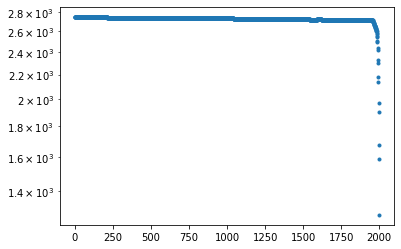

In [170]:
%matplotlib inline
plt.semilogy(solver.state_coeffs[:,:,2].ravel(), '.')

In [158]:
solver.params["ArtificialViscosity"], solver.params["AVParameter"]

(True, 500)

In [5]:
get_var = lambda name: solver.physics.compute_variable(name, solver.state_coeffs)
plt.plot(get_var("Pressure"))

TypeError: <lambda>() missing 1 required positional argument: 'name'